# Setup

In [1]:
# Extract and build the benchmark
!rm -f ipc/ipc-static
!rm -f ipc/ipc-dynamic
!make -C ipc
!sysctl kern.ipc.maxsockbuf=33554432

cc -DWITH_PMC -Wall -o ipc-static -DPROGNAME=\"ipc-static\" ipc.c -static  -lpmc -lpthread
cc -DWITH_PMC -Wall -o ipc-dynamic -DPROGNAME=\"ipc-dynamic\" ipc.c -dynamic  -lpmc -lpthread
cc -DWITH_PMC -Wall -o ipc-static-nonblock -DPROGNAME=\"ipc-static-nonblock\" ipc-nonblock.c -static  -lpmc -lpthread
ipc-nonblock.c:503:16: warning: unused variable 'bytes_to_write' [-Wunused-variable]
                const size_t bytes_to_write = min(buffersize, totalsize - write_sofar);
                             ^
1 warning generated.
kern.ipc.maxsockbuf: 2097152 -> 33554432


In [2]:
# D Language scripts
D_ctx_switch = """
    fbt::mi_switch:entry /execname == "ipc-static"/ { @["counts"] = count() }
"""

D_uiomove = """
    fbt::uiomove_faultflag:entry /execname == "ipc-static"/ { @ = count() }
"""

# Syscall/trap timing
D_sys_timing = """
syscall::clock_gettime:entry
/execname == "ipc-static" && self->in_benchmark/
{
    self->in_benchmark = 0
}

syscall::clock_gettime:return
/execname == "ipc-static" && !self->in_benchmark/
{
    self->in_benchmark = 1
}

syscall:::entry
/execname == "ipc-static"/
{
    @syscalls["syscall_count"] = count();
    self->start = timestamp;
    self->insyscall = 1;
}

syscall:::return
/execname == "ipc-static" && self->insyscall != 0/
{
    length = timestamp - self->start;
    @syscall_times[probefunc] = sum(length);
    @syscall_total["syscall_time"] = sum(length);
    self->insyscall = 0;
}

fbt::trapsignal:entry
/execname == "ipc-static" && self->insyscall == 0/
{
    @traps["trap_count"]= count();
    self->start = timestamp;
}

fbt::trapsignal:return
/execname == "ipc-static" && self->insyscall == 0/
{
    length = timestamp - self->start;
    @trap_total["trap_time"] = sum(length);
}

END
{
    printa(@syscall_times);

    printf("syscalls:"); printa(@syscalls);
    printf("total_syscalls:"); printa(@syscall_total);
    printf("traps:"); printa(@traps);
    printf("total_traps:"); printa(@trap_total);
}
"""

D_ipc_time = """
syscall::clock_gettime:return
/execname == "ipc-static" && !self->in_benchmark/
{
        self->ts = timestamp;
        self->vts = vtimestamp;
        self->wts = walltimestamp;
        self->in_benchmark = 1;
}

syscall::clock_gettime:entry
/execname == "ipc-static" && self->in_benchmark/
{
        diff = timestamp - self->ts;
        vdiff = vtimestamp - self->vts;
        wdiff = walltimestamp - self->wts;
        self->in_benchmark = 0;
        @len["time"] = sum(diff);
        @len["vtime"] = sum(vdiff);
        @len["wtime"] = sum(wdiff);
}

END
{
    printa(@len);
}
"""

D_rw_returns = """
syscall::read:entry
/execname == "ipc-static" && !self->in_read/
{
        self->in_read = 1;
        @["read_in"] = quantize(arg2);
}

syscall::read:return
/execname == "ipc-static" && self->in_read/
{
        self->in_read = 0;
        @["read_out"] = quantize((ssize_t)arg0);
}

syscall::write:entry
/execname == "ipc-static" && !self->in_write/
{
        self->in_write = 1;
        @["write_in"] = quantize(arg2);
}

syscall::write:return
/execname == "ipc-static" && self->in_write/
{
        self->in_write = 0;
        @["write_out"] = quantize((ssize_t)arg0);
}
"""

D_rw_returns_pairs = """
syscall::clock_gettime:entry
/execname == "ipc-static" && self->in_benchmark/
{
    self->in_benchmark = 0
}

syscall::clock_gettime:return
/execname == "ipc-static" && !self->in_benchmark/
{
    self->in_benchmark = 1
}

syscall::read:entry
/execname == "ipc-static" && self->in_benchmark/
{
        self->in_read = 1;
        self->in = (size_t)arg2;
}

syscall::read:return
/execname == "ipc-static" && self->in_benchmark/
{
        self->in_read = 0;
        self->out = (ssize_t)arg0;
        @reads["read", self->in, self->out] = count();
}

syscall::write:entry
/execname == "ipc-static" && self->in_benchmark/
{
        self->in_write = 1;
        self->in = (size_t)arg2;
}

syscall::write:return
/execname == "ipc-static" && self->in_benchmark/
{
        self->in_write = 0;
        self->out = (ssize_t)arg0;
        @writes["write", self->in, self->out] = count();
}

END
{
    printa(@reads);
    printa(@writes);
}
"""

'''
fbt::*pmap*:entry,
fbt::*page*:entry,
fbt::*copy*:entry
/execname== $$1/
{
    @traces[probefunc] = count()
}
'''

D_uio = '''
fbt::*uio*:entry
/execname == "ipc-static"/ 
{ 
        self->ts = timestamp;
        @calls[probefunc] = count();
}

fbt::*uio*:return
/execname == "ipc-static" && self->ts/ 
{ 
        @times[probefunc] = sum(timestamp - self->ts);
}

END
{
        printa(@calls);
        printa(@times);
}
'''

D_off_cpu = '''
syscall::clock_gettime:return
/execname == "ipc-static" && !in_bench/
{
        in_bench = 1;
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_bench/
{
        in_bench = 0;
}

sched:::off-cpu
/execname == "ipc-static" && in_bench/
{
        self->start = timestamp;
}

sched:::on-cpu
/self->start
        && (timestamp - self->start)
        && in_bench/
{
        /* @times = quantize(timestamp - self->start); */
        @total["total"] = sum(timestamp - self->start);
        /* @stacks[stack()] = count(); */
}
'''

D_vm_fault = '''
syscall::clock_gettime:return
/execname == "ipc-static" && !in_bench/
{
        in_bench = 1
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_bench/
{
        in_bench = 0
}

fbt::vm_fault:entry
/execname == "ipc-static" && in_bench/
{
        self->ts = vtimestamp;
}

fbt::vm_fault:return
/execname == "ipc-static"
        && self->ts
        && in_bench/
{
/*      @faults = quantize(vtimestamp - self->ts); */
        @times["times"] = sum(vtimestamp - self->ts);
        @counts["counts"] = count();
}
'''

D_sys_rw = '''
syscall::clock_gettime:return
/execname == "ipc-static" && !in_bench/
{
        in_bench = 1
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_bench/
{
        in_bench = 0
}

fbt::sys_read:entry
/execname == "ipc-static" && in_bench/
{
        self->rts = vtimestamp;
}

fbt::sys_read:return
/execname == "ipc-static" && in_bench && self->rts/
{
        @counts["counts"] = count();
        @times["times"] = sum(vtimestamp - self->rts);
}
'''

D_lock = '''
syscall::clock_gettime:return
/execname == "ipc-static" && !in_bench/
{
    in_bench = 1;
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_bench/
{
    in_bench = 0;
}

lockstat:::thread-spin
/execname == "ipc-static" && in_bench/
{
    @["count"] = count()
}
'''

In [3]:
import itertools
import re

def strs_to_tup(strs):
    if len(strs) == 1:
        return (strs[0].strip(),None)
    else:
        return (strs[0].strip(),strs[1].strip())

def flatten(lst):
    return list(itertools.chain.from_iterable(lst))

def parse(cmd_out):
    tups = map(strs_to_tup, [string.split(":") for string in cmd_out])
    return dict(tups)

def genfilename(exe, mode, ipc, runs, flags, suffix="", extension = "png"):
    return "{}_{}_{}_runs_{}_{}{}.{}".format(re.sub(r'[/-]', r'_', exe), mode, ipc, runs, re.sub(r'\s*-', r'', flags), suffix, extension)

def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

def gather_pmc_vals(table, data, pmc):
    if pmc == "mem":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['mem_read'] = [float(item["MEM_READ"]) for item in data]
        table['mem_read_per_cycle'] = [float(item["MEM_READ/CLOCK_CYCLES"]) for item in data]
        table['mem_read_per_instr'] = [float(item["MEM_READ/INSTR_EXECUTED"]) for item in data]
        table['mem_write'] = [float(item["MEM_WRITE"]) for item in data]
        table['mem_write_per_cycle'] = [float(item["MEM_WRITE/CLOCK_CYCLES"]) for item in data]
        table['mem_write_per_instr'] = [float(item["MEM_WRITE/INSTR_EXECUTED"]) for item in data]
    elif pmc == "l1d":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['l1d_hits'] = [float(item["L1_DCACHE_ACCESS"]) for item in data]
        table['l1d_hits_per_instr'] = [float(item["L1_DCACHE_ACCESS/INSTR_EXECUTED"]) for item in data]
        table['l1d_hits_per_cycle'] = [float(item["L1_DCACHE_ACCESS/CLOCK_CYCLES"]) for item in data]
        table['l1d_refill'] = [float(item["L1_DCACHE_REFILL"]) for item in data]
        table['l1d_refill_per_instr'] = [float(item["L1_DCACHE_REFILL/INSTR_EXECUTED"]) for item in data]
        table['l1d_refill_per_cycle'] = [float(item["L1_DCACHE_REFILL/CLOCK_CYCLES"]) for item in data]
    elif pmc == "l1i":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['l1i_refill'] = [float(item["L1_ICACHE_REFILL"]) for item in data]
        table['l1i_refill_per_instr'] = [float(item["L1_ICACHE_REFILL/INSTR_EXECUTED"]) for item in data]
        table['l1i_refill_per_cycle'] = [float(item["L1_ICACHE_REFILL/CLOCK_CYCLES"]) for item in data]
    elif pmc == "l2":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['l2_hit'] = [float(item["L2_ACCESS"]) for item in data]
        table['l2_hit_per_instr'] = [float(item["L2_ACCESS/INSTR_EXECUTED"]) for item in data]
        table['l2_hit_per_cycle'] = [float(item["L2_ACCESS/CLOCK_CYCLES"]) for item in data]
    elif pmc == "axi":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['axi_read'] = [float(item["AXI_READ"]) for item in data]
        table['axi_read_per_instr'] = [float(item["AXI_READ/INSTR_EXECUTED"]) for item in data]
        table['axi_read_per_cycle'] = [float(item["AXI_READ/CLOCK_CYCLES"]) for item in data]
        table['axi_write'] = [float(item["AXI_WRITE"]) for item in data]
        table['axi_write_per_instr'] = [float(item["AXI_WRITE/INSTR_EXECUTED"]) for item in data]
        table['axi_write_per_cycle'] = [float(item["AXI_WRITE/CLOCK_CYCLES"]) for item in data]
    elif pmc == "tlb":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['itlb_refill'] = [float(item["ITLB_REFILL"]) for item in data]
        table['itlb_refill_per_instr'] = [float(item["ITLB_REFILL/INSTR_EXECUTED"]) for item in data]
        table['itlb_refill_per_cycle'] = [float(item["ITLB_REFILL/CLOCK_CYCLES"]) for item in data]
        table['dtlb_refill'] = [float(item["DTLB_REFILL"]) for item in data]
        table['dtlb_refill_per_instr'] = [float(item["DTLB_REFILL/INSTR_EXECUTED"]) for item in data]
        table['dtlb_refill_per_cycle'] = [float(item["DTLB_REFILL/CLOCK_CYCLES"]) for item in data]
    else:
        raise ValueError("Wrong pmc type: {}".format(pmc))
    return table

print("Done with PMC setup")

Done with PMC setup


In [4]:
import time
from __future__ import print_function
from decimal import Decimal
import pandas as pd
import numpy as np
%matplotlib inline
# import matplotlib.pyplot as plt
#import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

def label_points(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], "{:.2E}".format(Decimal(point['x'])))

def graph(xs, ys, num_trials = 0, save = False, save_name = None, texty = 100, ylog = False, title = None, xlabel = None, ylabel = None, label = '_nolegend_', axis = None):
    # plt.style.use('seaborn-whitegrid')
    xvalues = np.reshape(ys, (len(xs), num_trials))[:,:]
    df = pd.DataFrame(xvalues, index=xs)
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]
    if axis is not None:
        ax = df.median(1).plot(yerr=error_bars_values, title=title, ax=axis, label = label)
    else:
        fig = plt.figure(figsize=(18,6))
        ax = df.median(1).plot(yerr=error_bars_values, title=title, label = label)

    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if label:
        ax.set_label(label)
    if title:
        ax.set_title(title)
    if ylog:
        ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xticks(df.index)
    ax.set_xticklabels(xs, rotation=45)
    plt.grid('on', axis='x' )
    plt.grid('on', axis='y' )
    plt.legend()
    if save_name is not None:
        ax.get_figure().savefig("{}".format(save_name))
    return ax

def benchmark(flags, repeat, exe, mode, ipc, buf_sizes, tot_sizes, dtrace_info = None, bench_name = "", pmc = None, quiet = False):
    runs = range(1, repeat + 1)
    outputs = []
    if not quiet:
        print("\t ==> Running {}".format(exe))
        print("\t\t ==> {} across {}".format(ipc, mode))
    is_dtrace = (dtrace_info != None)
    if is_dtrace and not quiet:
        print("\t\t ==> Running in DTrace mode")
    dtrace_thread = None
    verbose = "-v" in flags
    pmc_enabled = pmc is not None

    for buffer_size in buf_sizes:
        for tot_size in tot_sizes:
            cmd = "{} {} -i {} -b {} -t {} {}".format(exe, flags, ipc, buffer_size, tot_size, mode)

            discard = !{cmd} # Discard first benchmark run which may be biased
            if is_dtrace:
                dtraceSleep = dtrace_info['sleep'] if 'sleep' in dtrace_info else 1
                # Create a seperate thread to run the DTrace instrumentation
                dtrace_thread = DTraceConsumerThread(dtrace_info['script'],
                                                        chew_func=None,
                                                        chewrec_func=None,
                                                        walk_func=dtrace_info['agg_fn'],
                                                        sleep=dtraceSleep)
                # Start the DTrace instrumentation
                dtrace_thread.start()

            results = []
            for i in runs:
                out = !{cmd}
                parsed = parse(out)
                results.append(parsed)

            if is_dtrace and dtrace_thread != None:
                # The benchmark has completed - stop the DTrace instrumentation
                dtrace_thread.stop()
                dtrace_thread.join()
                dtrace_thread.consumer.__del__() # Memory leak workaround

            times = [float(item['time']) for item in results] if verbose else None
            avg_time = sum(times) / len(runs) if verbose else None

            speeds = [float(item['speed'].split(' ')[0]) for item in results] # Need to split by ' ' because output speed has units attached to it (see ipc.c)
            avg_speed = sum(speeds) / len(runs)
            if not quiet:
                print("\t\t\t{0:2} bytes {1:2} bytes: {2:.2f} KBytes/sec".format(buffer_size, tot_size, avg_speed))
            res = {'buffersize':buffer_size, 'time':avg_time, 'speed':avg_speed, 'tot_sz':tot_size, 'speeds': speeds, 'times': times}
            if pmc_enabled:
                pmc_data = gather_pmc_vals({}, results, pmc)

                avgs = {}
                for key,val in pmc_data.iteritems():
                    avg_key = "avg_" + key
                    avgs[avg_key] = sum(val) / len(runs)

                pmc_data['pmctype'] = results[0]["pmctype"]
                # Merge dictionaries
                pmc_data = merge_two_dicts(avgs, pmc_data)
                res = merge_two_dicts(res, pmc_data)
            outputs.append(res)
    return outputs

def highlight(axis, texty = 100):
    axis.axvspan(0, 8192, alpha=0.15, color='r')
    axis.axvspan(8193, 32768, alpha=0.15, color='g')
    axis.axvspan(32769, 65536, alpha=0.15, color='m')
    axis.axvspan(65537, 131072, alpha=0.15, color='c')
    axis.axvspan(131073, 262144, alpha=0.15, color='y')
    axis.text(3500, texty, "4K Page Size")
    axis.text(12000, texty, "16K PIPE_SIZE")
    axis.text(30000, texty, "32K L1")
    axis.text(90000, texty, "32x4K TLB entries")
    axis.text(250000, texty, "256K L2")

print("Set up completed")

Set up completed


# 1thread

## Vary IPC buffer (user-space)

	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 192328.81 KBytes/sec
			4096 bytes 16777216 bytes: 295830.90 KBytes/sec
			8192 bytes 16777216 bytes: 343635.29 KBytes/sec
			16384 bytes 16777216 bytes: 343061.82 KBytes/sec
			32768 bytes 16777216 bytes: 334006.30 KBytes/sec
			65536 bytes 16777216 bytes: 316417.48 KBytes/sec
			131072 bytes 16777216 bytes: 221737.16 KBytes/sec
			262144 bytes 16777216 bytes: 142129.23 KBytes/sec
			524288 bytes 16777216 bytes: 134209.92 KBytes/sec
			1048576 bytes 16777216 bytes: 133340.40 KBytes/sec
			2097152 bytes 16777216 bytes: 127498.68 KBytes/sec
			4194304 bytes 16777216 bytes: 120537.89 KBytes/sec
			8388608 bytes 16777216 bytes: 107382.15 KBytes/sec
			16777216 bytes 16777216 bytes: 87084.03 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 192368.24 KBytes/sec
			4096 bytes 16777216 bytes: 295610.84 KBytes/sec
			8192 bytes 16777216 bytes: 358863.73 KBytes

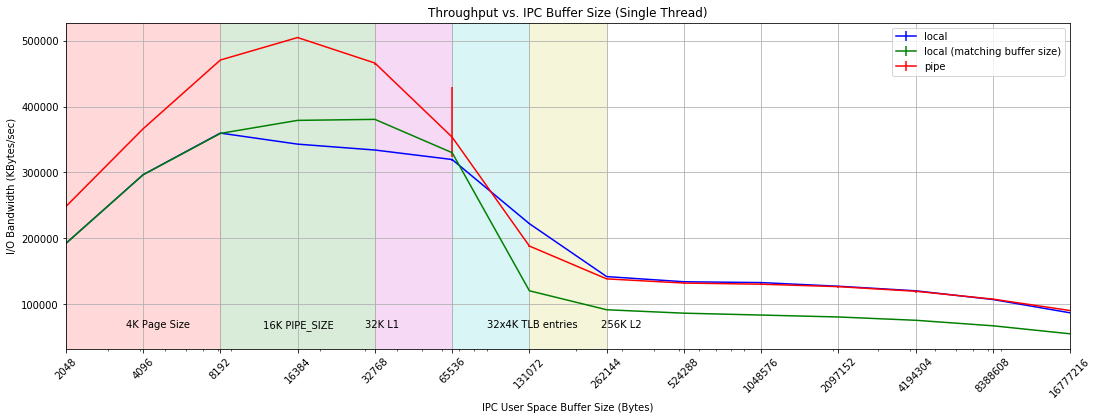

In [11]:
BUF_START = 512
#BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(8, 16)] # Start from 128KB
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""

MODE = "1thread"
IPC= "local"
#local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(local, "pkls/local_1thread.pkl")
local = pd.read_pickle("pkls/local_1thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS,
          xlabel='IPC User Space Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)',
          label=IPC, title = "Throughput vs. IPC Buffer Size (Single Thread)")

FLAGS="-s"
#local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(local, "pkls/local_s_1thread.pkl")
local = pd.read_pickle("pkls/local_s_1thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS,
          label=IPC + " (matching buffer size)", axis = p)

FLAGS=""
IPC= "pipe"
#pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(pipe, "pkls/pipe_1thread.pkl")
pipe = pd.read_pickle("pkls/pipe_1thread.pkl")
highlight(p, texty = 65000)
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "vary_buffer")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p,
            label=IPC, save = True, save_name = saveas)

## 2thread

	 ==> Running ipc/ipc-static
		 ==> pipe across 2thread
			2048 bytes 16777216 bytes: 173781.54 KBytes/sec
			4096 bytes 16777216 bytes: 238737.09 KBytes/sec
			8192 bytes 16777216 bytes: 276813.72 KBytes/sec
			16384 bytes 16777216 bytes: 389215.41 KBytes/sec
			32768 bytes 16777216 bytes: 494210.18 KBytes/sec
			65536 bytes 16777216 bytes: 554708.82 KBytes/sec
			131072 bytes 16777216 bytes: 312979.26 KBytes/sec
			262144 bytes 16777216 bytes: 169148.27 KBytes/sec
			524288 bytes 16777216 bytes: 157736.07 KBytes/sec
			1048576 bytes 16777216 bytes: 154179.30 KBytes/sec
			2097152 bytes 16777216 bytes: 148407.87 KBytes/sec
			4194304 bytes 16777216 bytes: 140160.90 KBytes/sec
			8388608 bytes 16777216 bytes: 127081.90 KBytes/sec
			16777216 bytes 16777216 bytes: 106398.66 KBytes/sec


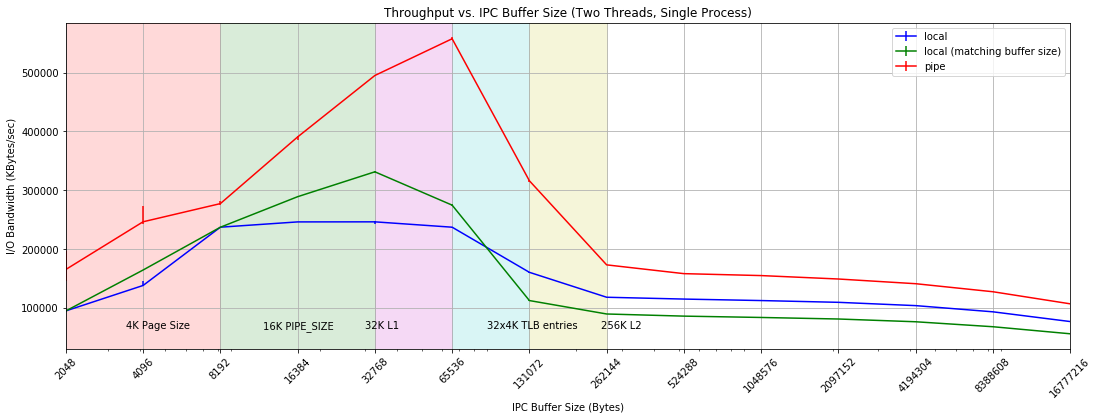

In [6]:
BUF_START = 512
#BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(8, 16)] # Start from 128KB
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""

MODE = "2thread"
IPC= "local"
#local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(local, "./local_2thread.pkl")
local = pd.read_pickle("pkls/local_2thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS,
            xlabel='IPC Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)',
              label=IPC, title = "Throughput vs. IPC Buffer Size (Two Threads, Single Process)")

FLAGS="-s"
#local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(local, "./local_s_2thread.pkl")
local = pd.read_pickle("pkls/local_s_2thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS,
          label=IPC + " (matching buffer size)", axis = p)

FLAGS=""
IPC= "pipe"
#pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(pipe, "./pipe_2thread.pkl")
pipe = pd.read_pickle("pkls/pipe_2thread.pkl")
highlight(p, texty = 65000)
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "vary_buffer")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

## 2proc

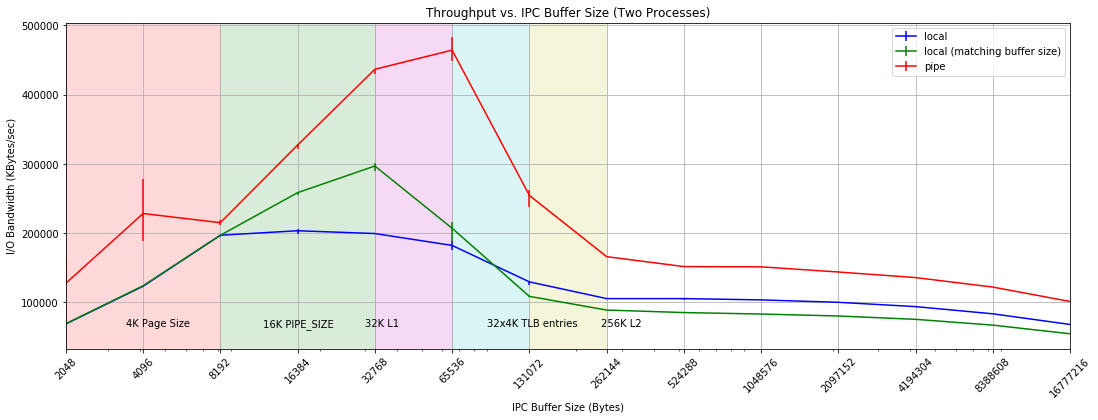

In [54]:
BUF_START = 512
#BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(8, 16)] # Start from 128KB
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""

MODE = "2proc"
IPC= "local"
#local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(local, "./local_2proc.pkl")
local = pd.read_pickle("pkls/local_2proc.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS,
          xlabel='IPC Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)',
          label=IPC, title = "Throughput vs. IPC Buffer Size (Two Processes)")

FLAGS="-s"
#local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(local, "./local_s_2proc.pkl")
local = pd.read_pickle("pkls/local_s_2proc.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS,
          label=IPC + " (matching buffer size)", axis = p)

FLAGS=""
IPC= "pipe"
#pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(pipe, "./pipe_2proc.pkl")
pipe = pd.read_pickle("pkls/pipe_2proc.pkl")
highlight(p, texty = 65000)
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "vary_buffer")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p,
          label=IPC, save = True, save_name = saveas)

# Thread Model

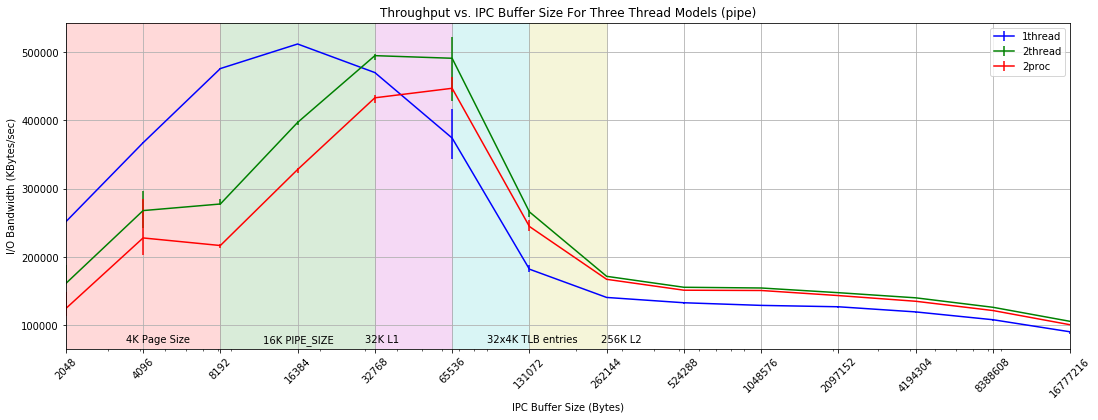

In [12]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]]
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""
IPC= "pipe"

MODE = "1thread"
#thread1 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(thread1, "./mc_pipe_1thread.pkl")
thread1 = pd.read_pickle("pkls/mc_pipe_1thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread1]), RUNS,
          xlabel='IPC Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)',
          label=MODE, title = "Throughput vs. IPC Buffer Size For Three Thread Models (pipe)")

MODE = "2thread"
#thread2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(thread2, "./mc_pipe_2thread.pkl")
thread2 = pd.read_pickle("pkls/mc_pipe_2thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread2]), RUNS,
          label=MODE, axis = p)

MODE = "2proc"
#proc2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(proc2, "./mc_pipe_2proc.pkl")
proc2 = pd.read_pickle("pkls/mc_pipe_2proc.pkl")
highlight(p, texty = 75000)
saveas = genfilename(EXE, MODE, "pipe", RUNS, FLAGS, suffix = "vary_thread_model")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in proc2]), RUNS, axis = p,
          label=MODE, save = True, save_name = saveas)

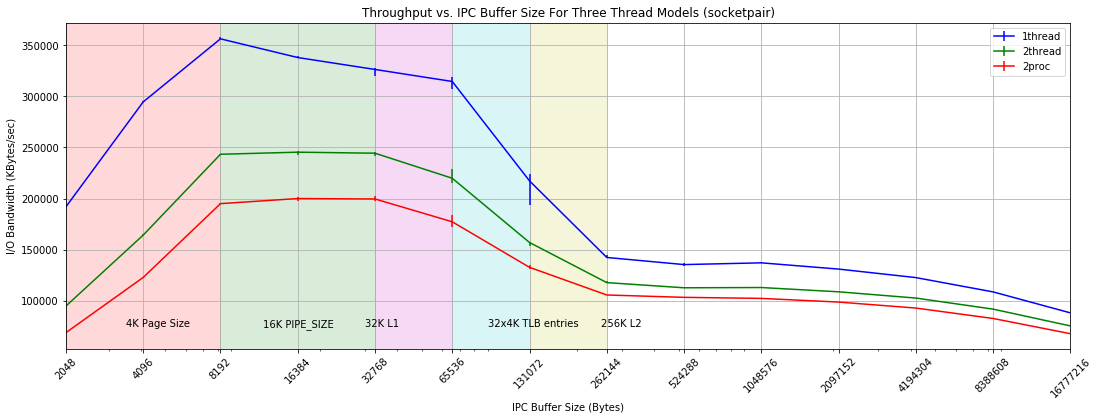

In [13]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]]
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""
IPC= "local"

MODE = "1thread"
#thread1 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(thread1, "./mc_local_1thread.pkl")
thread1 = pd.read_pickle("pkls/mc_local_1thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread1]), RUNS,
          xlabel='IPC Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)',
          label=MODE, title = "Throughput vs. IPC Buffer Size For Three Thread Models (socketpair)")

MODE = "2thread"
#thread2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(thread2, "./mc_local_2thread.pkl")
thread2 = pd.read_pickle("pkls/mc_local_2thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread2]), RUNS,
          label=MODE, axis = p)

MODE = "2proc"
#proc2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(proc2, "./mc_local_2proc.pkl")
proc2 = pd.read_pickle("pkls/mc_local_2proc.pkl")
highlight(p, texty = 75000)
saveas = genfilename(EXE, MODE, "local", RUNS, FLAGS, suffix = "vary_thread_model")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in proc2]), RUNS, axis = p,
          label=MODE, save = True, save_name = saveas)

	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 185434.76 KBytes/sec
			4096 bytes 16777216 bytes: 285987.01 KBytes/sec
			8192 bytes 16777216 bytes: 355506.84 KBytes/sec
			16384 bytes 16777216 bytes: 377197.45 KBytes/sec
			32768 bytes 16777216 bytes: 382351.00 KBytes/sec
			65536 bytes 16777216 bytes: 288857.76 KBytes/sec
			131072 bytes 16777216 bytes: 122683.97 KBytes/sec
			262144 bytes 16777216 bytes: 92792.89 KBytes/sec
			524288 bytes 16777216 bytes: 87442.43 KBytes/sec
			1048576 bytes 16777216 bytes: 84732.49 KBytes/sec
			2097152 bytes 16777216 bytes: 81791.67 KBytes/sec
			4194304 bytes 16777216 bytes: 76738.03 KBytes/sec
			8388608 bytes 16777216 bytes: 63298.35 KBytes/sec
			16777216 bytes 16777216 bytes: 55782.00 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 2thread
			2048 bytes 16777216 bytes: 93040.02 KBytes/sec
			4096 bytes 16777216 bytes: 156747.02 KBytes/sec
			8192 bytes 16777216 bytes: 240409.71 KBytes/sec
		

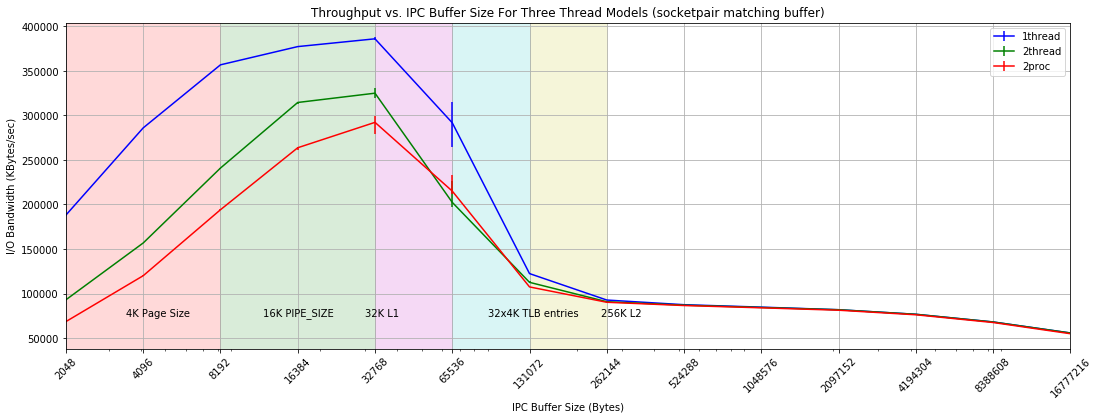

In [33]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]]
RUNS = 12
EXE="ipc/ipc-static"
FLAGS="-s"
IPC= "local"

MODE = "1thread"
thread1 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
pd.to_pickle(thread1, "pkls/mc_local_s_1thread.pkl")
#thread1 = pd.read_pickle("pkls/mc_local_s_1thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread1]), RUNS,
          xlabel='IPC Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)',
          label=MODE, title = "Throughput vs. IPC Buffer Size For Three Thread Models (socketpair matching buffer)")

MODE = "2thread"
thread2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
pd.to_pickle(thread2, "pkls/mc_local_s_2thread.pkl")
#thread2 = pd.read_pickle("pkls/mc_local_s_2thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread2]), RUNS,
          label=MODE, axis = p)

MODE = "2proc"
proc2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
pd.to_pickle(proc2, "./mc_local_s_2proc.pkl")
#proc2 = pd.read_pickle("pkls/mc_local_s_2proc.pkl")
highlight(p, texty = 75000)
saveas = genfilename(EXE, MODE, "local", RUNS, FLAGS, suffix = "vary_thread_model")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in proc2]), RUNS, axis = p,
          label=MODE, save = True, save_name = saveas)

# DTrace

In [31]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16, 2)] # step == 2: even numbers
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
DTRACE_RUNS = 1
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""

def calc_bw(data):
    sortedKeys = data.keys()
    sortedKeys.sort()
    for buf in sortedKeys:
        ns = float(data[buf]['vtime']) / float(1e9)
        print(str((buf / 1024) / ns) + " KB/sec.")

def process_rw_pairs(data):
    sortedKeys = data.keys()
    sortedKeys.sort()
    reads = []
    writes = []
    read_ratios = {}
    write_ratios = {}
    for buf in sortedKeys:
        reads.append([(tup[0][1], tup[0][2], tup[1], buf) for tup in data[buf] if tup[0][0] == 'read'])
        writes.append([(tup[0][1], tup[0][2], tup[1], buf) for tup in data[buf] if tup[0][0] == 'write'])
    for bufArr in reads:
        for tup in bufArr:
            ratio = float(tup[1]) / float(tup[0]) if tup[1] > 0 else tup[1]
            sz = tup[3]
            if sz in read_ratios:
                read_ratios[sz] += [ratio] * tup[2]
            else:
                read_ratios[sz] = [ratio] * tup[2]
    for bufArr in writes:
        for tup in bufArr:
            ratio = float(tup[1]) / float(tup[0]) if tup[1] > 0 else tup[1]
            sz = tup[3]
            if sz in write_ratios:
                write_ratios[sz] += [ratio] * tup[2]
            else:
                write_ratios[sz] = [ratio] * tup[2]
    return {'reads' : read_ratios,
             'writes': write_ratios}

def graph_rw_pairs(pairs, key, title="", xlabel="", ylabel="Frequency", saveas = None):
    frames = []
    sortedKeys = pairs[key].keys()
    sortedKeys.sort()
    for sz in sortedKeys:
        frames.append(pd.DataFrame(pairs[key][sz], columns = [sz]))
    df = pd.concat(frames, axis=1)
    ax = df.plot(kind='hist', bins=50, log=True, stacked=True, figsize=(20,10), title=title)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if saveas is not None:
        ax.get_figure().savefig("{}".format(saveas))

# Callbacks invoked to process the aggregation
def test_agg(a, b, c, d):
    values = {}
    print("From DTrace: {} | {} | {} | val: {}".format(a,b,c,d))

def simple_agg(a, b, c, d):
    values.append(d)

def acc_agg(a, b, c, d):
    if c[0] not in values:
        values[c[0]] = [d]
    else:
        values[c[0]].append(d)

def map_agg(a, b, c, d):
    if len(c):
        values[c[0]] = d

def pair_agg(a, b, c, d):
    values.append((c, d))

def quantized_agg(a, b, c, d):
    dist = d
    filtered = [tup if tup[0][0] >= -2 and tup[0][0] <= BUFFER_SIZES[-1] else None for tup in dist]
    filtered = [x for x in filtered if x is not None ]
    values[c[0]] = filtered

## Partial Reads/Writes

	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
		 ==> Running in DTrace mode
			2048 bytes 8388608 bytes: 22529.89 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
		 ==> Running in DTrace mode
			8192 bytes 8388608 bytes: 79367.23 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
		 ==> Running in DTrace mode
			32768 bytes 8388608 bytes: 194675.83 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
		 ==> Running in DTrace mode
			131072 bytes 8388608 bytes: 122896.63 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
		 ==> Running in DTrace mode
			524288 bytes 8388608 bytes: 97929.31 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
		 ==> Running in DTrace mode
			2097152 bytes 8388608 bytes: 89483.95 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
		 ==> Running in DTrace mode
			8388608 bytes 8388608 bytes: 67047.72 KBytes/sec


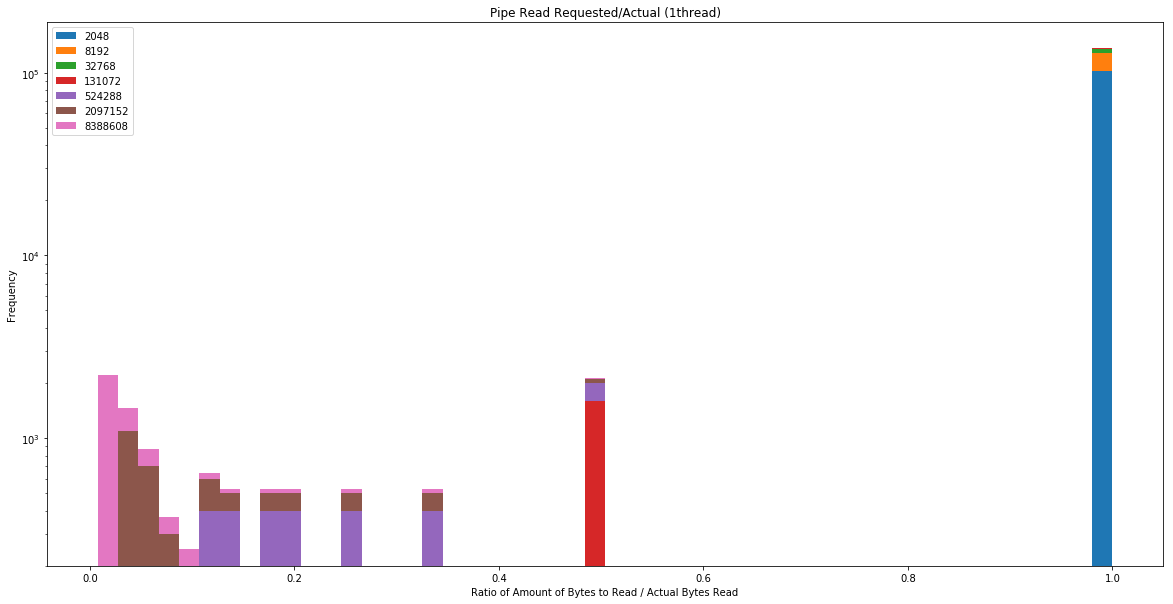

In [13]:
MODE = "1thread"
IPC= "pipe"
results = {}
for tot_sz in TOT_SIZES:
    for buf_sz in BUFFER_SIZES:
        values = [] # Change depending on agg function. E.g. could be init'd to {}
        benchmark(FLAGS, RUNS, EXE, MODE, IPC, [buf_sz], [tot_sz], dtrace_info = {'agg_fn':pair_agg, 'script':D_rw_returns_pairs})
        results[buf_sz] = values
pairs = process_rw_pairs(results)
saveas = genfilename(EXE, MODE, "", RUNS, FLAGS, suffix = "partial_reads")
graph_rw_pairs(pairs, 'reads', xlabel="Ratio of Amount of Bytes to Read / Actual Bytes Read",
               ylabel="Frequency", title="Pipe Read Requested/Actual (1thread)", saveas = saveas)

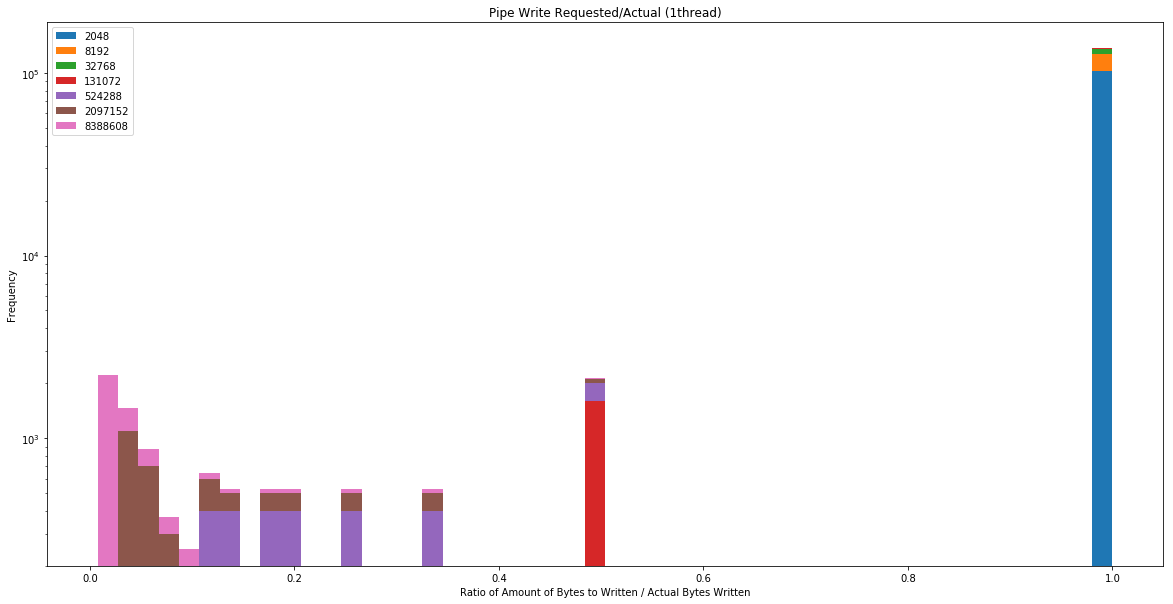

In [14]:
saveas = genfilename(EXE, MODE, "", RUNS, FLAGS, suffix = "partial_writes")
graph_rw_pairs(pairs, 'writes', xlabel="Ratio of Amount of Bytes to Written / Actual Bytes Written",
               ylabel="Frequency", title="Pipe Write Requested/Actual (1thread)", saveas = saveas)

	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			2048 bytes 8388608 bytes: 21105.23 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			8192 bytes 8388608 bytes: 73289.41 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			32768 bytes 8388608 bytes: 69815.15 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			131072 bytes 8388608 bytes: 54777.17 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			524288 bytes 8388608 bytes: 48543.71 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			2097152 bytes 8388608 bytes: 45089.81 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			8388608 bytes 8388608 bytes: 33666.87 KBytes/sec


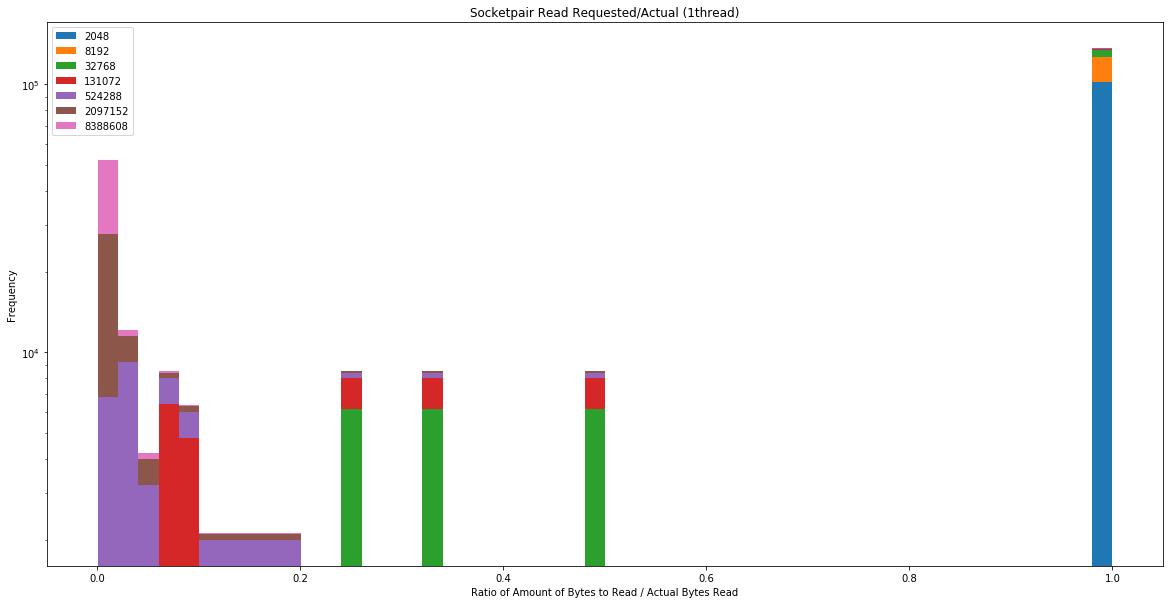

In [15]:
MODE = "1thread"
IPC= "local"
results = {}
for tot_sz in TOT_SIZES:
    for buf_sz in BUFFER_SIZES:
        values = [] # Change depending on agg function. E.g. could be init'd to {}
        benchmark(FLAGS, RUNS, EXE, MODE, IPC, [buf_sz], [tot_sz], dtrace_info = {'agg_fn':pair_agg, 'script':D_rw_returns_pairs})
        results[buf_sz] = values
pairs = process_rw_pairs(results)
saveas = genfilename(EXE, MODE, "", RUNS, FLAGS, suffix = "partial_reads")
graph_rw_pairs(pairs, 'reads', xlabel="Ratio of Amount of Bytes to Read / Actual Bytes Read",
               ylabel="Frequency", title="Socketpair Read Requested/Actual (1thread)", saveas = saveas)

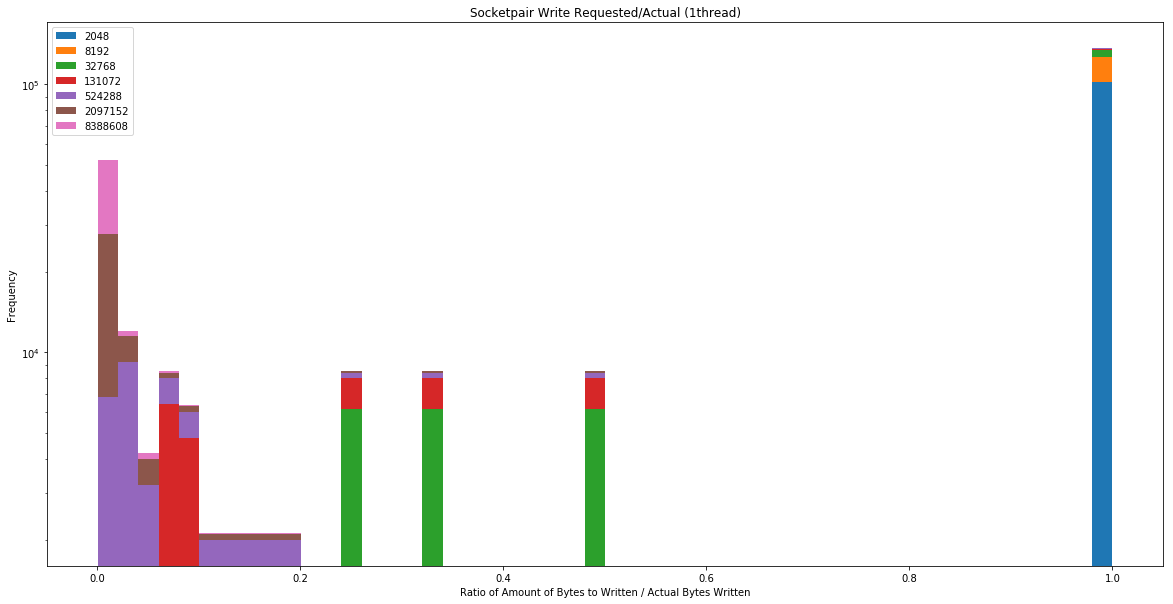

In [16]:
saveas = genfilename(EXE, MODE, "", RUNS, FLAGS, suffix = "partial_writes")
graph_rw_pairs(pairs, 'writes', xlabel="Ratio of Amount of Bytes to Written / Actual Bytes Written", ylabel="Frequency",
               title="Socketpair Write Requested/Actual (1thread)", saveas = saveas)

	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			2048 bytes 8388608 bytes: 21278.93 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			8192 bytes 8388608 bytes: 73442.39 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			32768 bytes 8388608 bytes: 168681.50 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			131072 bytes 8388608 bytes: 95992.51 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			524288 bytes 8388608 bytes: 80035.20 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			2097152 bytes 8388608 bytes: 70157.40 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
		 ==> Running in DTrace mode
			8388608 bytes 8388608 bytes: 54634.62 KBytes/sec


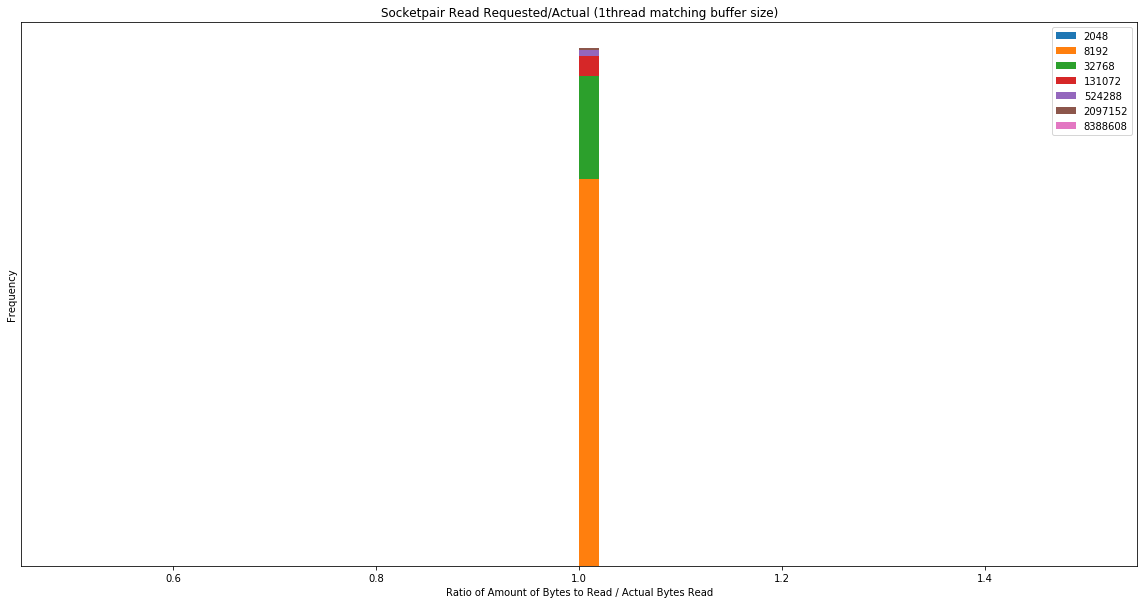

In [17]:
MODE = "1thread"
IPC= "local"
FLAGS="-s"
results = {}
for tot_sz in TOT_SIZES:
    for buf_sz in BUFFER_SIZES:
        values = [] # Change depending on agg function. E.g. could be init'd to {}
        benchmark(FLAGS, RUNS, EXE, MODE, IPC, [buf_sz], [tot_sz], dtrace_info = {'agg_fn':pair_agg, 'script':D_rw_returns_pairs})
        results[buf_sz] = values
pairs = process_rw_pairs(results)
saveas = genfilename(EXE, MODE, "", RUNS, FLAGS, suffix = "partial_reads")
graph_rw_pairs(pairs, 'reads', xlabel="Ratio of Amount of Bytes to Read / Actual Bytes Read", ylabel="Frequency",
               title="Socketpair Read Requested/Actual (1thread matching buffer size)", saveas = saveas)

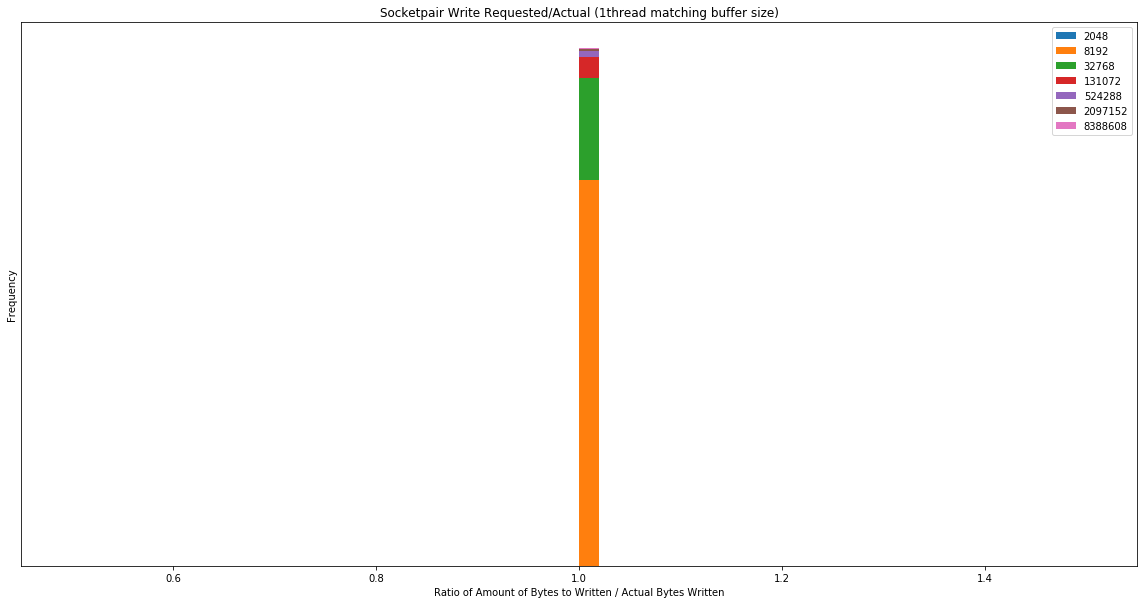

In [18]:
saveas = genfilename(EXE, MODE, "", RUNS, FLAGS, suffix = "partial_writes")
graph_rw_pairs(pairs, 'writes', xlabel="Ratio of Amount of Bytes to Written / Actual Bytes Written",
               ylabel="Frequency", title="Socketpair Write Requested/Actual (1thread matching buffer size)",
               saveas = saveas)

## vm_fault/pmap_fault

In [123]:
# https://www.freebsd.org/doc/en/articles/vm-design/prefault-optimizations.html: optmization occurs but still overhead exists
modes = ["2thread", "2proc"]
ipc= "pipe"
runs=2
buffs = [512 * 2 ** exp for exp in range(2, 16)]
totsz = [BUFFER_SIZES[-1]]

out = {}
for mode in modes:
    print("")
    print("DTracing " + mode)
    results = {}
    for i in range(1, runs + 1):
        for tot_sz in totsz:
            for buf_sz in buffs:
                values = {} # Change depending on agg function. E.g. could be init'd to {}
                benchmark("", 1, "ipc/ipc-static", mode, ipc, [buf_sz], [tot_sz],
                          dtrace_info = {'agg_fn':map_agg, 'script': D_vm_fault, 'sleep': 2}, quiet = True)
                if buf_sz not in results:
                    results[buf_sz] = [values]
                else:
                    results[buf_sz].append(values)
                print(buf_sz, end=" ")
        print(".", end=" ")
    out[mode] = results

with open("vm_fault_dtrace_pipe_thread_models.pkl", 'wb') as handle:
    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)


DTracing 2thread
2048 4096 8192 16384 32768 65536 131072 262144 524288 1048576 2097152 4194304 8388608 16777216 . 2048 4096 8192 16384 32768 65536 131072 262144 524288 1048576 2097152 4194304 8388608 16777216 . 
DTracing 2proc
2048 4096 8192 16384 32768 65536 131072 262144 524288 1048576 2097152 4194304 8388608 16777216 . 2048 4096 8192 16384 32768 65536 131072 262144 524288 1048576 2097152 4194304 8388608 16777216 . 

[530401, 536372, 533469, 541728, 133574, 139194, 220179, 210867, 271570, 280425, 426724, 397895, 633022, 624317, 1090066, 1093147, 2025437, 2043408, 3918068, 3945827, 7633555, 7718889, 15112604, 15095768, 30565183, 30727756, 61491201, 60926961]
[30, 30, 30, 30, 2, 2, 7, 7, 11, 11, 20, 20, 35, 35, 67, 67, 131, 131, 259, 259, 515, 515, 1027, 1027, 2051, 2051, 4099, 4099]
[834157, 766168, 816149, 726800, 465335, 448229, 456934, 446643, 517725, 514827, 643918, 626957, 898404, 893739, 1374563, 1370716, 2394179, 2312217, 4334211, 4380860, 8363362, 8283913, 16402772, 16562127, 32441298, 32465436, 64236431, 63950646]
[38, 38, 38, 38, 17, 17, 20, 20, 24, 24, 33, 33, 49, 49, 81, 81, 144, 144, 272, 272, 527, 527, 1039, 1039, 2063, 2063, 4111, 4111]


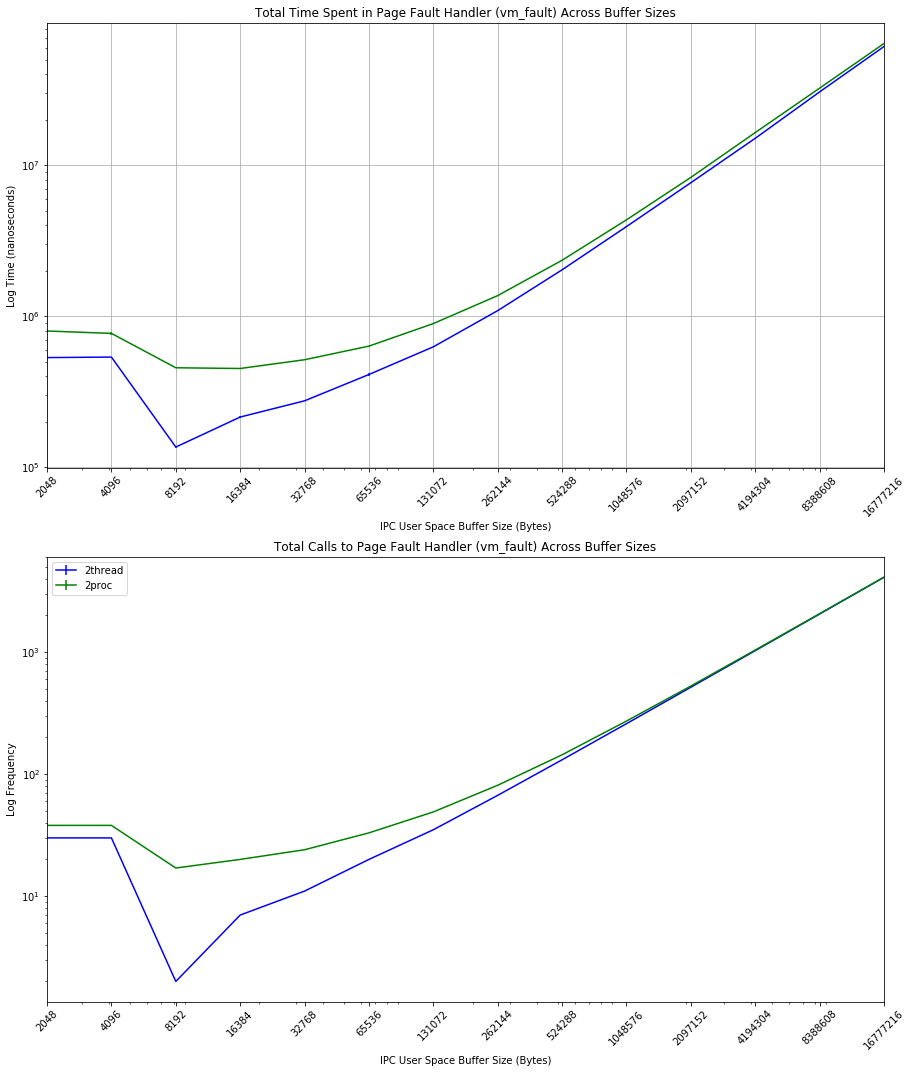

In [132]:
# TODO: statistical test
# TODO: vm_page_alloc + notable functions called + mention trap time couldn't be calculated + Context Switches
# TODO: time spent in pipe_write/pipe_read
# TODO: nosleep test
times = []
counts = []
thread2 = out["2thread"]
ks = thread2.keys()
ks.sort()
for k in ks:
    vs = thread2[k]
    times.append([v['times'] for v in vs])
    counts.append([v['counts'] for v in vs])
times = flatten(times)
print(times)
counts = flatten(counts)
print(counts)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,18))
p = graph(buffs, times, runs, xlabel='IPC User Space Buffer Size (Bytes)',
            ylabel='Log Time (nanoseconds)', label="2thread",
              title = "Total Time Spent in Page Fault Handler (vm_fault) Across Buffer Sizes", ylog = True, axis = ax1)
pcount = graph(buffs, counts, runs, xlabel='IPC User Space Buffer Size (Bytes)',
            ylabel='Log Frequency', label="2thread",
              title = "Total Calls to Page Fault Handler (vm_fault) Across Buffer Sizes", ylog = True, axis = ax2)

times = []
counts = []
proc2 = out["2proc"]
ks = proc2.keys()
ks.sort()
for k in ks:
    vs = proc2[k]
    times.append([v['times'] for v in vs])
    counts.append([v['counts'] for v in vs])
times = flatten(times)
print(times)
counts = flatten(counts)
print(counts)
p = graph(buffs, times, runs, label="2proc", axis=ax1, ylog = True)
pcount = graph(buffs, counts, runs, label="2proc", axis=ax2, ylog = True)
ax1.grid()
ax2.grid()

In [6]:
data = {'2thread':[],'2thread_s':[],'2proc':[], '2proc_s': []}
RUNS = 10
FLAGS = ""
EXE = "ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
for sz in BUFFER_SIZES:
    text_file = open("data/vmfault.out_{}_local_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "vm_fault" in l and "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc"] += nums
    text_file = open("data/vmfault.out_{}_local_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "vm_fault" in l and "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2thread"] += nums
    text_file = open("data/vmfault.out_{}_local_s_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "vm_fault" in l and "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_s"] += nums
    text_file = open("data/vmfault.out_{}_local_s_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "vm_fault" in l and "count" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2thread_s"] += nums

p = graph(BUFFER_SIZES,data['2proc'], RUNS, label="2proc off-cpu")
p = graph(BUFFER_SIZES,data['2thread'], RUNS, label="2proc off-cpu", axis = p)
p = graph(BUFFER_SIZES,data['2proc_s'], RUNS, label="2proc off-cpu", axis = p)
p = graph(BUFFER_SIZES,data['2thread_s'], RUNS, label="2proc off-cpu", axis = p)

IOError: [Errno 2] No such file or directory: 'data/vmfault.out_2thread_local_s_2048'

## Lock Contention

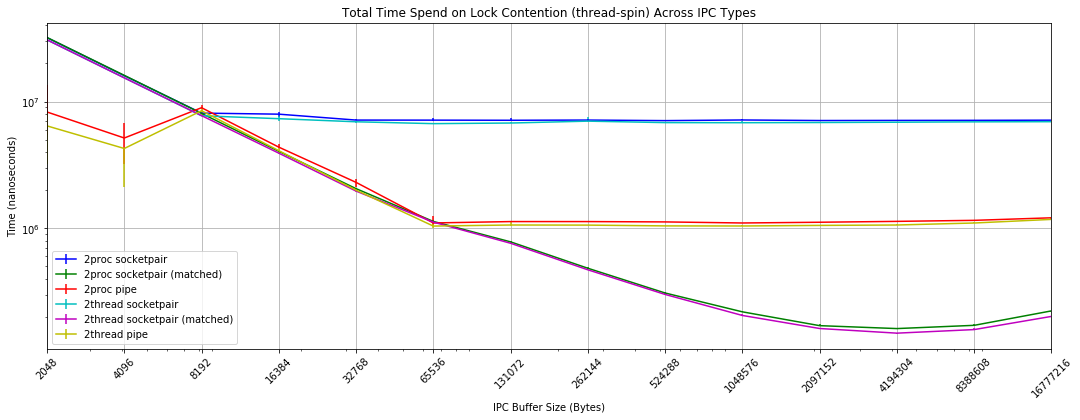

In [8]:
data = {'2thread':[],'2thread_s':[],'2proc':[], '2proc_s': [],'2proc_pipe':[], '2thread_pipe': []}
RUNS = 10
FLAGS = ""
EXE = "ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
for sz in BUFFER_SIZES:
    text_file = open("data/lock.out_{}_local_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc"] += nums
    text_file = open("data/lock.out_{}_local_s_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_s"] += nums
    text_file = open("data/lock.out_{}_local_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2thread"] += nums
    text_file = open("data/lock.out_{}_local_s_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2thread_s"] += nums
    text_file = open("data/lock.out_{}_pipe_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2thread_pipe"] += nums
    text_file = open("data/lock.out_{}_pipe_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_pipe"] += nums

p = graph(BUFFER_SIZES,data['2proc'], RUNS, label="2proc socketpair", xlabel = "IPC Buffer Size (Bytes)",
             ylabel="Time (nanoseconds)", title = "Total Time Spend on Lock Contention (thread-spin) Across IPC Types",
                 ylog = True)
p = graph(BUFFER_SIZES,data['2proc_s'], RUNS, label="2proc socketpair (matched)",axis = p)
p = graph(BUFFER_SIZES,data['2proc_pipe'], RUNS, label="2proc pipe",axis = p)
p = graph(BUFFER_SIZES,data['2thread'], RUNS, label="2thread socketpair",axis = p)
p = graph(BUFFER_SIZES,data['2thread_s'], RUNS, label="2thread socketpair (matched)",axis = p)
saveas = genfilename(EXE, "all_modes", "all_ipc", RUNS, FLAGS, suffix = "lock_contention")
p = graph(BUFFER_SIZES,data['2thread_pipe'], RUNS, label="2thread pipe",axis = p, save_name = saveas)

## pmap

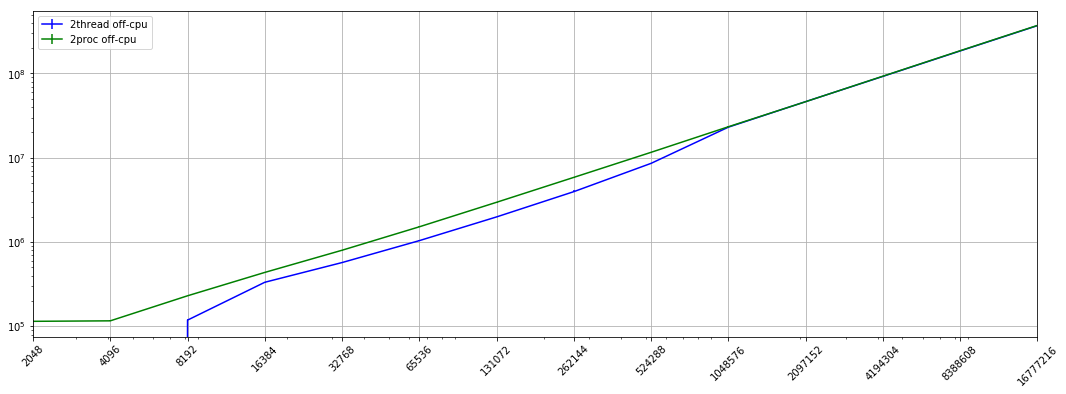

In [6]:
data = {'2thread':[], '2thread_prefault':[],'2proc':[], '2proc_prefault':[]}
RUNS = 10
FLAGS = ""
EXE = "ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
for sz in BUFFER_SIZES:
    text_file = open("data/pmap.out_{}_local_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "vm_reserv_alloc_page" in l and "total" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2proc"] += nums
    text_file = open("data/pmap.out_{}_local_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "vm_reserv_alloc_page" in l and "total" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2thread"] += nums

p = graph(BUFFER_SIZES,data['2thread'], RUNS, label="2thread off-cpu", ylog = True)
p = graph(BUFFER_SIZES,data['2proc'], RUNS, label="2proc off-cpu", axis = p)

## Off-cpu (local matching)

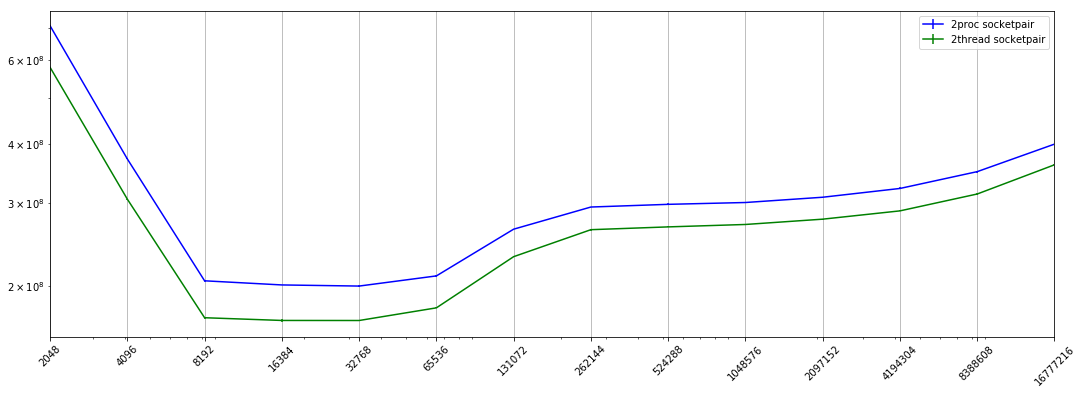

In [13]:
data = {'2thread':[], '2thread_pipe':[],'2proc':[], '2proc_pipe':[],'2proc_local_s':[], '2thread_local_s':[]}
RUNS = 10
FLAGS = ""
EXE = "ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
for sz in BUFFER_SIZES:
    text_file = open("data/offcpu.out_{}_local_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc"] += nums
    text_file = open("data/offcpu.out_{}_local_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2thread"] += nums
    # text_file = open("data/offcpu.out_{}_pipe_{}".format("2proc", sz), "r")
    # lines = text_file.read().split("\n")
    # lines = [l.strip().split()[1] for l in lines if "total" in l]
    # nums = [int(n) for n in lines if n is not '']
    # data["2proc_pipe"] += nums
    # text_file = open("data/offcpu.out_{}_pipe_{}".format("2thread", sz), "r")
    # lines = text_file.read().split("\n")
    # lines = [l.strip().split()[1] for l in lines if "total" in l]
    # nums = [int(n) for n in lines if n is not '']
    # data["2thread_pipe"] += nums
    text_file = open("data/offcpu.out_{}_local_s_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_local_s"] += nums
    text_file = open("data/offcpu.out_{}_local_s_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    newLines = []
    for l in lines:
        if "total" in l:
            stripped = l.strip().split()
            if len(stripped) > 1:
                newLines.append(stripped[1])
            else:
                newLines.append(0)
    lines = newLines
    nums = [int(n) for n in lines if n is not '']
    data["2thread_local_s"] += nums


p = graph(BUFFER_SIZES,data['2proc'], RUNS, label="2proc socketpair", ylog = True)
#p = graph(BUFFER_SIZES,data['2proc_pipe'], RUNS, label="2proc pipe", axis = p)
#p = graph(BUFFER_SIZES,data['2proc_local_s'], RUNS, label="2proc socketpair (matching)", axis = p)
p = graph(BUFFER_SIZES,data['2thread'], RUNS, label="2thread socketpair", axis = p)
#p = graph(BUFFER_SIZES,data['2thread_pipe'], RUNS, label="2thread pipe", axis = p)
#p = graph(BUFFER_SIZES,data['2thread_local_s'], RUNS, label="2thread socketpair (matching)", axis = p)

## Syscalls/Traps

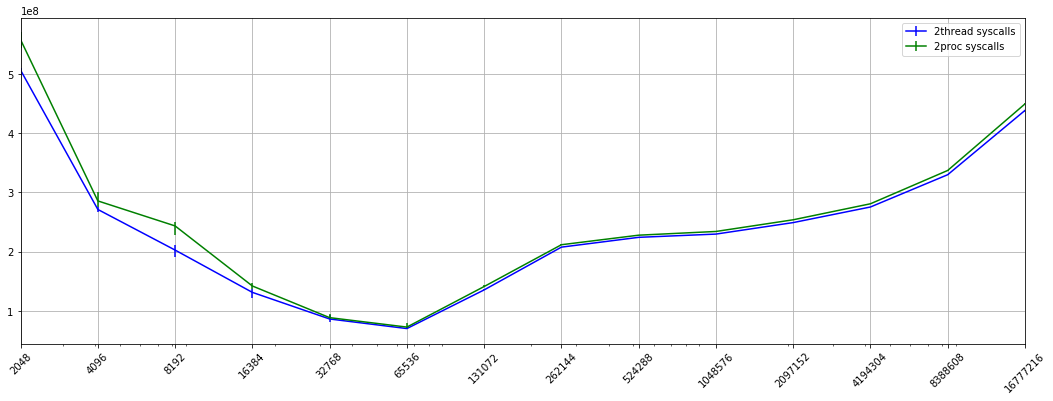

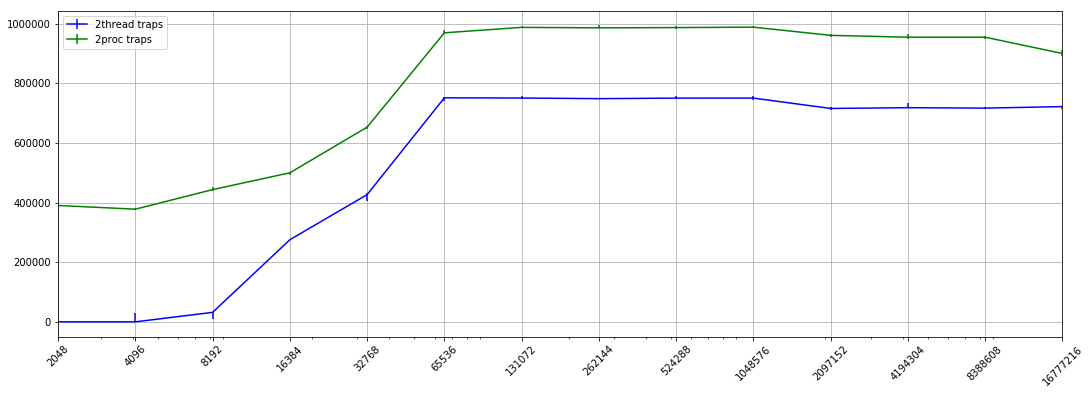

In [7]:
data = {'2thread_sys':[], '2thread_trap':[],'2proc_sys':[], '2proc_trap':[],'2proc_trap_s':[], '2proc_sys_s':[]}
RUNS = 10
FLAGS = ""
EXE = "ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
for sz in BUFFER_SIZES:
    text_file = open("data/sys.out_{}_pipe_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "syscall_total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2thread_sys"] += nums
    text_file = open("data/sys.out_{}_pipe_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "trap_total" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2thread_trap"] += nums
    text_file = open("data/sys.out_{}_pipe_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "syscall_total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_sys"] += nums
    text_file = open("data/sys.out_{}_pipe_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "trap_total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_trap"] += nums

    text_file = open("data/sys.out_{}_local_s_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "syscall_total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_sys_s"] += nums
    text_file = open("data/sys.out_{}_local_s_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "trap_total" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_trap_s"] += nums


p = graph(BUFFER_SIZES,data['2thread_sys'], RUNS, label="2thread syscalls")
p = graph(BUFFER_SIZES,data['2proc_sys'], RUNS, label="2proc syscalls", axis = p)
#p = graph(BUFFER_SIZES,data['2proc_sys_s'], RUNS, label="2proc syscalls (matching)", axis = p)

p = graph(BUFFER_SIZES,data['2thread_trap'], RUNS, label="2thread traps")
p = graph(BUFFER_SIZES,data['2proc_trap'], RUNS, label="2proc traps", axis = p)
#p = graph(BUFFER_SIZES,data['2proc_trap_s'], RUNS, label="2proc traps (matching)", axis = p)

## uio

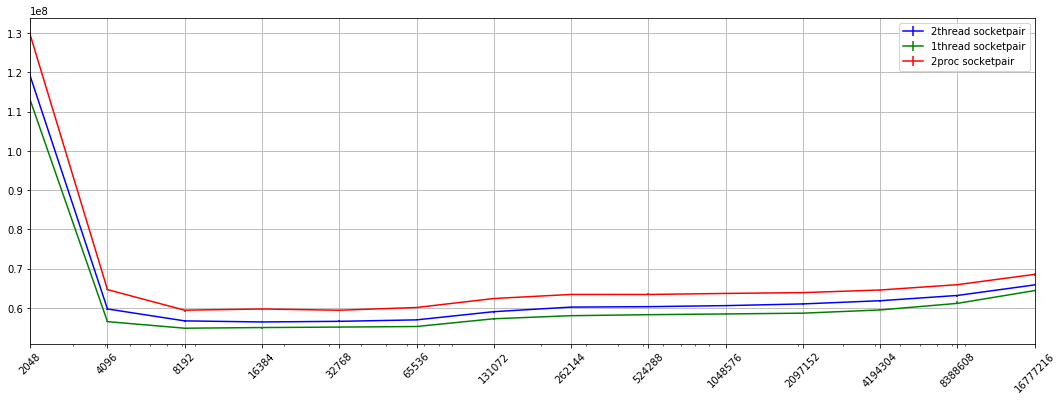

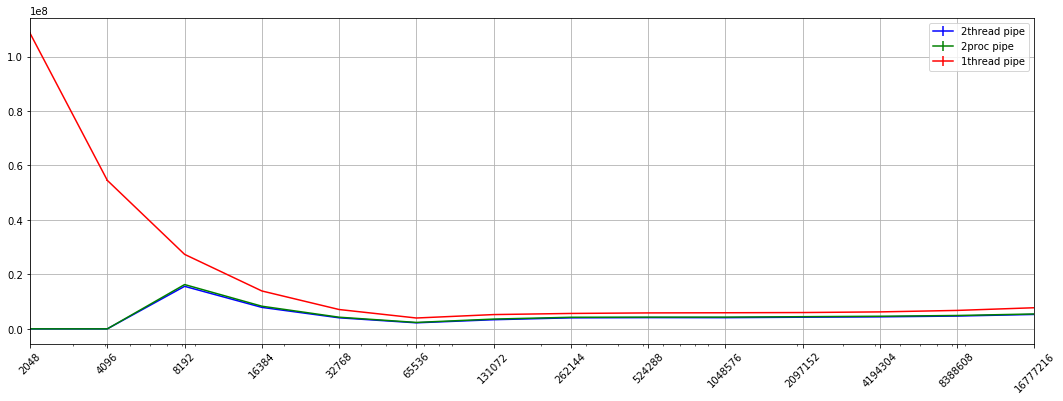

In [12]:
data = {'2thread_fault':[], '2proc_fault':[],
        '2thread_phys':[], '2proc_phys':[],
        '1thread_fault_pipe':[],'1thread_fault_local':[]
       }
RUNS = 10
FLAGS = ""
EXE = "ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
for sz in BUFFER_SIZES:
    text_file = open("data/uio.out_{}_local_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2thread_fault"] += nums
    text_file = open("data/uio.out_{}_local_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_fault"] += nums
    text_file = open("data/uio.out_{}_pipe_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "phys" in l] # TODO: add faultflag time?
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2thread_phys"] += nums
    text_file = open("data/uio.out_{}_pipe_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "phys" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2proc_phys"] += nums

    text_file = open("data/uio.out_{}_local_{}".format("1thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["1thread_fault_local"] += nums
    text_file = open("data/uio.out_{}_pipe_{}".format("1thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["1thread_fault_pipe"] += nums

p = graph(BUFFER_SIZES,data['2thread_fault'], RUNS, label="2thread socketpair")
p = graph(BUFFER_SIZES,data['1thread_fault_local'], RUNS, label="1thread socketpair", axis = p)
p = graph(BUFFER_SIZES,data['2proc_fault'], RUNS, label="2proc socketpair", axis = p)
# Pipes
p = graph(BUFFER_SIZES,data['2thread_phys'], RUNS, label="2thread pipe")
p = graph(BUFFER_SIZES,data['2proc_phys'], RUNS, label="2proc pipe", axis = p)
p = graph(BUFFER_SIZES,data['1thread_fault_pipe'], RUNS, label="1thread pipe", axis = p)

## Page Allocations/Zeroing

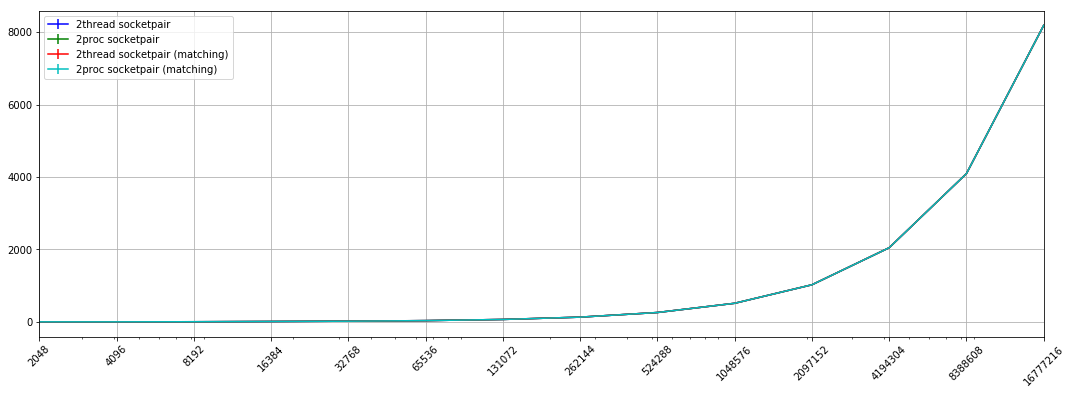

In [10]:
data = {'2thread':[], '2proc':[], '2thread_s':[],'2proc_s':[]}
RUNS = 10
FLAGS = ""
EXE = "ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
for sz in BUFFER_SIZES:
    text_file = open("data/page.out_{}_local_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "zero" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2thread"] += nums
    text_file = open("data/page.out_{}_local_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "zero" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2proc"] += nums
    text_file = open("data/page.out_{}_local_s_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "zero" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2thread_s"] += nums
    text_file = open("data/page.out_{}_local_s_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "zero" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2proc_s"] += nums

p = graph(BUFFER_SIZES,data['2thread'], RUNS, label="2thread socketpair")
p = graph(BUFFER_SIZES,data['2proc'], RUNS, label="2proc socketpair", axis = p)
p = graph(BUFFER_SIZES,data['2thread_s'], RUNS, label="2thread socketpair (matching)", axis = p)
p = graph(BUFFER_SIZES,data['2proc_s'], RUNS, label="2proc socketpair (matching)", axis = p)

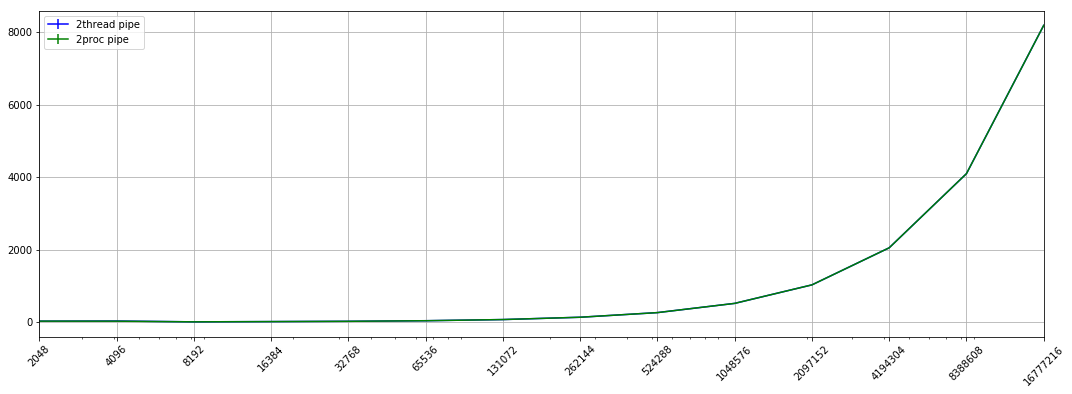

In [10]:
data = {'2thread':[], '2proc':[], '2thread_s':[],'2proc_s':[]}
RUNS = 10
FLAGS = ""
EXE = "ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
for sz in BUFFER_SIZES:
    text_file = open("data/page.out_{}_pipe_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "zero" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2thread"] += nums
    text_file = open("data/page.out_{}_pipe_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[2] for l in lines if "zero" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2proc"] += nums

p = graph(BUFFER_SIZES,data['2thread'], RUNS, label="2thread pipe")
p = graph(BUFFER_SIZES,data['2proc'], RUNS, label="2proc pipe", axis = p)

## Probe Effect

### Effect of DTrace

In [20]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""

def dummy_agg(a, b, c, d):
    pass

	 ==> Running ipc/ipc-static
		 ==> local across 2thread
		 ==> Running in DTrace mode
			2048 bytes 16777216 bytes: 26988.65 KBytes/sec
			4096 bytes 16777216 bytes: 51831.51 KBytes/sec
			8192 bytes 16777216 bytes: 96355.36 KBytes/sec
			16384 bytes 16777216 bytes: 112555.74 KBytes/sec
			32768 bytes 16777216 bytes: 119725.12 KBytes/sec
			65536 bytes 16777216 bytes: 108425.34 KBytes/sec
			131072 bytes 16777216 bytes: 86243.08 KBytes/sec
			262144 bytes 16777216 bytes: 75781.21 KBytes/sec
			524288 bytes 16777216 bytes: 75380.55 KBytes/sec
			1048576 bytes 16777216 bytes: 73954.83 KBytes/sec
			2097152 bytes 16777216 bytes: 72489.91 KBytes/sec
			4194304 bytes 16777216 bytes: 70466.61 KBytes/sec
			8388608 bytes 16777216 bytes: 63468.21 KBytes/sec
			16777216 bytes 16777216 bytes: 50558.53 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 2thread
		 ==> Running in DTrace mode
			2048 bytes 16777216 bytes: 28914.84 KBytes/sec
			4096 bytes 16777216 bytes: 54710.96 KBytes/se

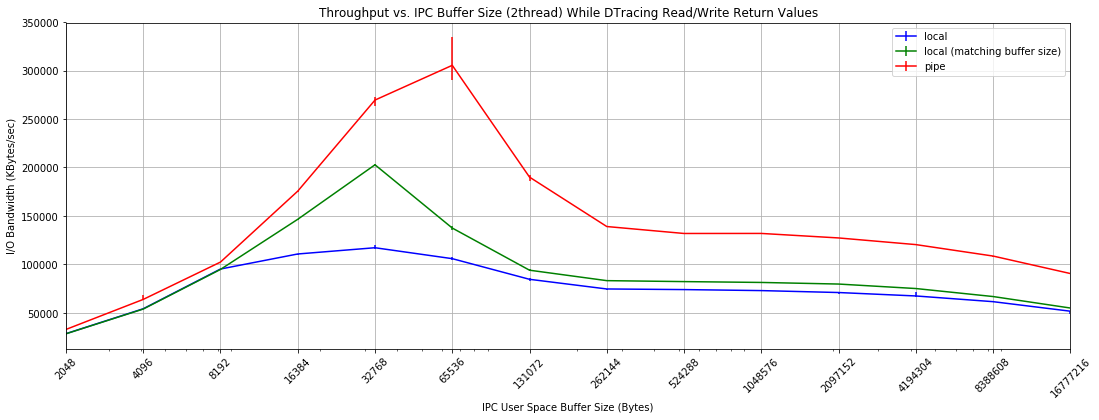

In [10]:
MODE="2thread"
IPC= "local"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_rw_returns_pairs})
pd.to_pickle(local, "pkls/local_2thread_probe_reads.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC User Space Buffer Size (Bytes)',
            ylabel='I/O Bandwidth (KBytes/sec)', label=IPC, title = "Throughput vs. IPC Buffer Size (2thread) While DTracing Read/Write Return Values")

FLAGS="-s"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_rw_returns_pairs})
pd.to_pickle(local, "pkls/local_s_2thread_probe_reads.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, axis = p,
          label=IPC + " (matching buffer size)")

FLAGS=""
IPC= "pipe"
pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_rw_returns_pairs})
pd.to_pickle(pipe, "pkls/pipe_2thread_probe_reads.pkl")
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "probe_effect_dtrace_reads")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC,
          save = True, save_name = saveas)

	 ==> Running ipc/ipc-static
		 ==> local across 2thread
		 ==> Running in DTrace mode
			2048 bytes 16777216 bytes: 27335.22 KBytes/sec
			4096 bytes 16777216 bytes: 52267.83 KBytes/sec
			8192 bytes 16777216 bytes: 92682.45 KBytes/sec
			16384 bytes 16777216 bytes: 109373.76 KBytes/sec
			32768 bytes 16777216 bytes: 113877.40 KBytes/sec
			65536 bytes 16777216 bytes: 105183.73 KBytes/sec
			131072 bytes 16777216 bytes: 85440.16 KBytes/sec
			262144 bytes 16777216 bytes: 75242.64 KBytes/sec
			524288 bytes 16777216 bytes: 74008.45 KBytes/sec
			1048576 bytes 16777216 bytes: 73014.34 KBytes/sec
			2097152 bytes 16777216 bytes: 71002.23 KBytes/sec
			4194304 bytes 16777216 bytes: 67906.80 KBytes/sec
			8388608 bytes 16777216 bytes: 62048.86 KBytes/sec
			16777216 bytes 16777216 bytes: 53495.96 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 2thread
		 ==> Running in DTrace mode
			2048 bytes 16777216 bytes: 27229.17 KBytes/sec
			4096 bytes 16777216 bytes: 52236.38 KBytes/se

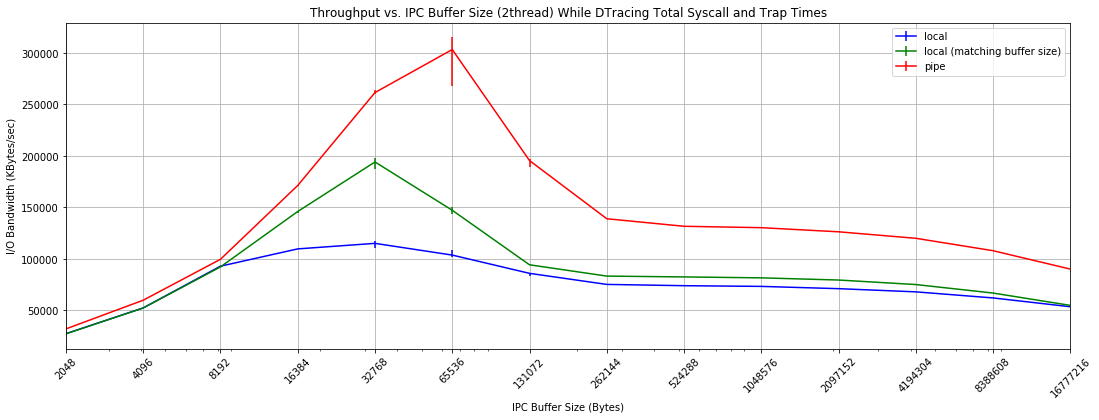

In [11]:
MODE="2thread"
IPC= "local"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_sys_timing})
pd.to_pickle(pipe, "pkls/local_2thread_probe_sys.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC Buffer Size (Bytes)',
            ylabel='I/O Bandwidth (KBytes/sec)', label=IPC,
                title = "Throughput vs. IPC Buffer Size (2thread) While DTracing Total Syscall and Trap Times")

FLAGS="-s"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_sys_timing})
pd.to_pickle(local, "pkls/local_s_2thread_probe_sys.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, axis = p,
          label=IPC + " (matching buffer size)")

FLAGS=""
IPC= "pipe"
pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_sys_timing})
pd.to_pickle(pipe, "pkls/pipe_2thread_probe_sys.pkl")
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "probe_effect_dtrace_sys")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC, save = True,
          save_name = saveas)

In [ ]:
MODE="2proc"
IPC= "local"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_sys_timing})
pd.to_pickle(pipe, "pkls/local_proc_probe_sys.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC Buffer Size (Bytes)',
            ylabel='I/O Bandwidth (KBytes/sec)', label=IPC,
                title = "Throughput vs. IPC Buffer Size (2proc) While DTracing Total Syscall and Trap Times")

FLAGS="-s"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_sys_timing})
pd.to_pickle(local, "pkls/local_s_2proc_probe_sys.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, axis = p,
          label=IPC + " (matching buffer size)")

FLAGS=""
IPC= "pipe"
pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_sys_timing})
pd.to_pickle(pipe, "pkls/pipe_2proc_probe_sys.pkl")
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "probe_effect_dtrace_sys")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC, save = True,
          save_name = saveas)

	 ==> Running ipc/ipc-static
		 ==> pipe across 2proc
		 ==> Running in DTrace mode
			2048 bytes 16777216 bytes: 93461.22 KBytes/sec
			4096 bytes 16777216 bytes: 149069.55 KBytes/sec
			8192 bytes 16777216 bytes: 111833.93 KBytes/sec
			16384 bytes 16777216 bytes: 189128.87 KBytes/sec
			32768 bytes 16777216 bytes: 284653.27 KBytes/sec
			65536 bytes 16777216 bytes: 336256.73 KBytes/sec
			131072 bytes 16777216 bytes: 193147.02 KBytes/sec
			262144 bytes 16777216 bytes: 136795.75 KBytes/sec
			524288 bytes 16777216 bytes: 128384.02 KBytes/sec
			1048576 bytes 16777216 bytes: 128309.15 KBytes/sec
			2097152 bytes 16777216 bytes: 122294.76 KBytes/sec
			4194304 bytes 16777216 bytes: 115358.76 KBytes/sec
			8388608 bytes 16777216 bytes: 104274.26 KBytes/sec
			16777216 bytes 16777216 bytes: 86836.83 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
		 ==> Running in DTrace mode
			2048 bytes 16777216 bytes: 245922.67 KBytes/sec
			4096 bytes 16777216 bytes: 361921.28 KB

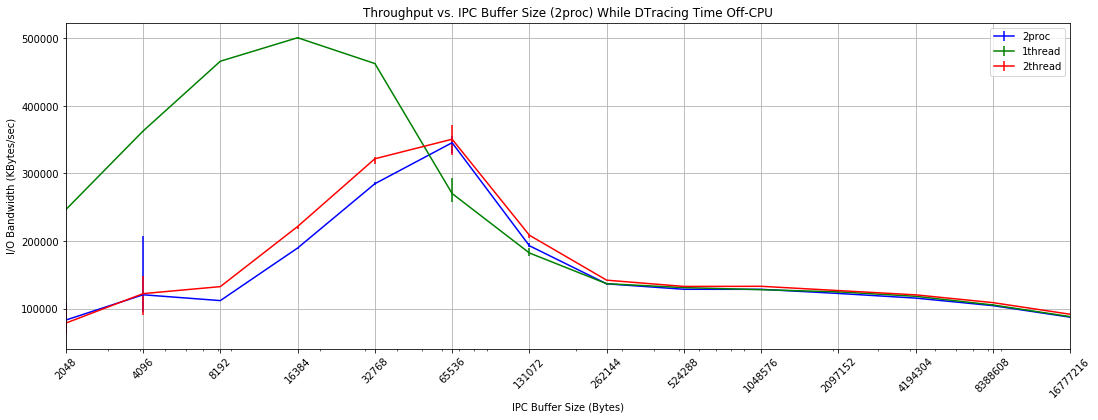

In [22]:
MODE="2proc"
IPC= "pipe"
proc2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_off_cpu})
pd.to_pickle(proc2, "pkls/pipe_2proc_probe_off_cpu.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in proc2]), RUNS, xlabel='IPC Buffer Size (Bytes)',
            ylabel='I/O Bandwidth (KBytes/sec)', label=MODE,
                title = "Throughput vs. IPC Buffer Size (2proc) While DTracing Time Off-CPU")

MODE="1thread"
thread1 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_off_cpu})
pd.to_pickle(thread1, "pkls/pipe_1thread_probe_off_cpu.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread1]), RUNS, axis = p, label=MODE)

MODE="2thread"
thread2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_off_cpu})
pd.to_pickle(thread2, "pkls/pipe_2thread_probe_off_cpu.pkl")
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "probe_effect_dtrace_off_cpu")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread2]), RUNS, axis = p, label=MODE, save = True,
          save_name = saveas)

### Effect of PMC

	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 127895.84 KBytes/sec
			4096 bytes 16777216 bytes: 119480.45 KBytes/sec
			8192 bytes 16777216 bytes: 190491.63 KBytes/sec
			16384 bytes 16777216 bytes: 187181.88 KBytes/sec
			32768 bytes 16777216 bytes: 182007.13 KBytes/sec
			65536 bytes 16777216 bytes: 174173.71 KBytes/sec
			131072 bytes 16777216 bytes: 136784.36 KBytes/sec
			262144 bytes 16777216 bytes: 106111.27 KBytes/sec
			524288 bytes 16777216 bytes: 102474.40 KBytes/sec
			1048576 bytes 16777216 bytes: 102984.92 KBytes/sec
			2097152 bytes 16777216 bytes: 99077.20 KBytes/sec
			4194304 bytes 16777216 bytes: 94096.88 KBytes/sec
			8388608 bytes 16777216 bytes: 84889.18 KBytes/sec
			16777216 bytes 16777216 bytes: 71014.80 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 128158.90 KBytes/sec
			4096 bytes 16777216 bytes: 119613.50 KBytes/sec
			8192 bytes 16777216 bytes: 190578.91 KBytes/se

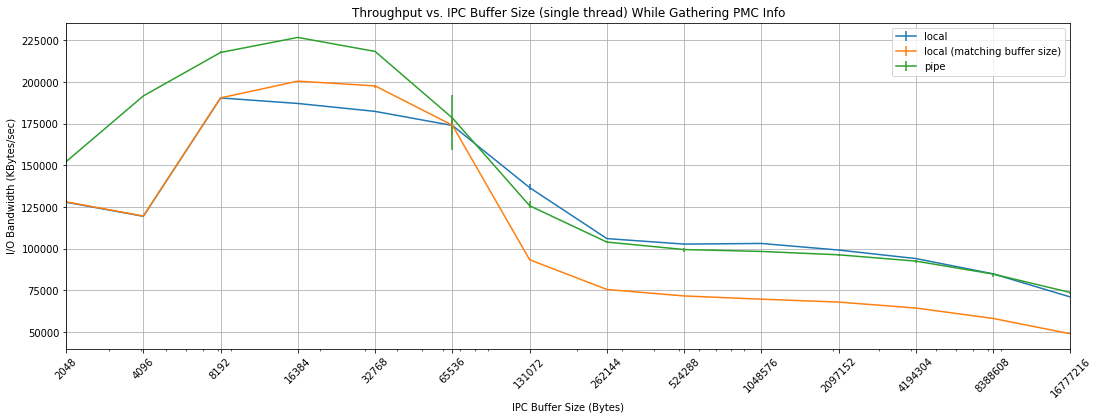

In [8]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
FLAGS="-P l1d"
EXE="ipc/ipc-static"
MODE = "1thread"
PMC="l1d"

IPC= "local"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, pmc = PMC)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC Buffer Size (Bytes)',
            ylabel='I/O Bandwidth (KBytes/sec)', label=IPC,
              title = "Throughput vs. IPC Buffer Size (single thread) While Gathering PMC Info")

FLAGS+=" -s"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, pmc = PMC)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, axis = p,
          label=IPC + " (matching buffer size)")

FLAGS="-P l1d"
IPC= "pipe"
pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, pmc = PMC)
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "probe_effect_pmc")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC, save = True,
            save_name = saveas)

	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 129009.11 KBytes/sec
			4096 bytes 16777216 bytes: 120577.44 KBytes/sec
			8192 bytes 16777216 bytes: 191916.73 KBytes/sec
			16384 bytes 16777216 bytes: 188474.30 KBytes/sec
			32768 bytes 16777216 bytes: 179088.44 KBytes/sec
			65536 bytes 16777216 bytes: 170363.65 KBytes/sec
			131072 bytes 16777216 bytes: 125590.48 KBytes/sec
			262144 bytes 16777216 bytes: 106669.03 KBytes/sec
			524288 bytes 16777216 bytes: 103035.68 KBytes/sec
			1048576 bytes 16777216 bytes: 101948.75 KBytes/sec
			2097152 bytes 16777216 bytes: 99511.22 KBytes/sec
			4194304 bytes 16777216 bytes: 94561.24 KBytes/sec
			8388608 bytes 16777216 bytes: 85338.78 KBytes/sec
			16777216 bytes 16777216 bytes: 67322.80 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 130880.64 KBytes/sec
			4096 bytes 16777216 bytes: 120794.44 KBytes/sec
			8192 bytes 16777216 bytes: 192224.94 KBytes/se

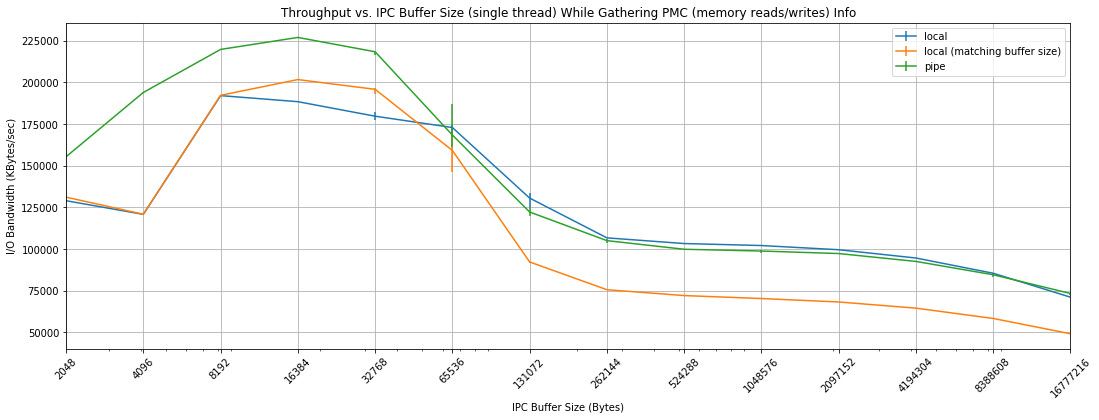

In [11]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
FLAGS="-P mem"
EXE="ipc/ipc-static"
MODE = "1thread"
PMC="mem"

IPC= "local"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, pmc = PMC)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, xlabel='IPC Buffer Size (Bytes)',
            ylabel='I/O Bandwidth (KBytes/sec)', label=IPC,
              title = "Throughput vs. IPC Buffer Size (single thread) While Gathering PMC (memory reads/writes) Info")

FLAGS+=" -s"
local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, pmc = PMC)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS, axis = p,
          label=IPC + " (matching buffer size)")

FLAGS="-P mem"
IPC= "pipe"
pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, pmc = PMC)
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "probe_effect_pmc")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC, save = True,
            save_name = saveas)

# PMC

In [6]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]]
RUNS = 12
EXE="ipc/ipc-static"

def graph_pmc(ipcs, mode, pmc, props):
    FLAGS="-P {}".format(pmc)
    res = {}
    for obj in ipcs:
        tmpFlags = FLAGS + " -s" if obj == "match" else FLAGS
        tmpObj = "local" if obj == "match" else obj
        res[obj] = benchmark(tmpFlags, RUNS, EXE, mode, tmpObj, BUFFER_SIZES, TOT_SIZES, pmc = pmc)

    for p in props:
        ax = None
        for obj in ipcs:
            label = "local (matching buffer size)" if obj == "match" else obj
            saveas = None if obj != ipcs[-1] else genfilename(EXE, mode, "all", RUNS, FLAGS, suffix = "pmc_" + p)
            pickle_name = genfilename(EXE, mode, "all", RUNS, FLAGS, suffix = "pmc_" + p, extension = ".pkl")
            pd.to_pickle(res[obj], pickle_name)
            ax = graph(BUFFER_SIZES, flatten([item[p] for item in res[obj]]),
                        RUNS, label=label, axis = ax,
                            title = "PMC {} on {} Across Varying IPC Buffer Sizes".format(p, mode),
                              xlabel = "Buffer Size (Bytes)", ylabel=p, save_name = saveas)


def graph_mc_pmc(ipc, modes, pmc, props):
    FLAGS="-P {}".format(pmc)
    FLAGS += " -s" if ipc == "match" else ""
    ipcObj = "local" if ipc == "match" else ipc
    ipcLabel = "local (matching buffer size)" if ipc == "match" else ipc
    res = {}
    for mode in modes:
        res[mode] = benchmark(FLAGS, RUNS, EXE, mode, ipcObj, BUFFER_SIZES, TOT_SIZES, pmc = pmc)

    for p in props:
        ax = None
        for mode in modes:
            saveas = None if mode != modes[-1] else genfilename(EXE, mode, ipcObj, RUNS, FLAGS, suffix = "mc_pmc_" + p)
            pickle_name = genfilename(EXE, mode, ipcObj, RUNS, FLAGS, suffix = "mc_pmc_" + p, extension = ".pkl")
            pd.to_pickle(res[mode], pickle_name)
            ax = graph(BUFFER_SIZES, flatten([item[p] for item in res[mode]]),
                        RUNS, label=mode, axis = ax,
                            title = "PMC {} vs. IPC Buffer Sizes on 1thread/2thread/2proc for {}".format(p, ipcLabel),
                              xlabel = "Buffer Size (Bytes)", ylabel=p, save_name = saveas)

	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
			2048 bytes 16777216 bytes: 153565.63 KBytes/sec
			4096 bytes 16777216 bytes: 180591.73 KBytes/sec
			8192 bytes 16777216 bytes: 220456.14 KBytes/sec
			16384 bytes 16777216 bytes: 227529.56 KBytes/sec
			32768 bytes 16777216 bytes: 218347.89 KBytes/sec
			65536 bytes 16777216 bytes: 189655.98 KBytes/sec
			131072 bytes 16777216 bytes: 126246.75 KBytes/sec
			262144 bytes 16777216 bytes: 102447.17 KBytes/sec
			524288 bytes 16777216 bytes: 99180.47 KBytes/sec
			1048576 bytes 16777216 bytes: 97583.99 KBytes/sec
			2097152 bytes 16777216 bytes: 95769.80 KBytes/sec
			4194304 bytes 16777216 bytes: 91092.67 KBytes/sec
			8388608 bytes 16777216 bytes: 84427.41 KBytes/sec
			16777216 bytes 16777216 bytes: 73257.93 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 130861.34 KBytes/sec
			4096 bytes 16777216 bytes: 170884.51 KBytes/sec
			8192 bytes 16777216 bytes: 194457.40 KBytes/sec
	

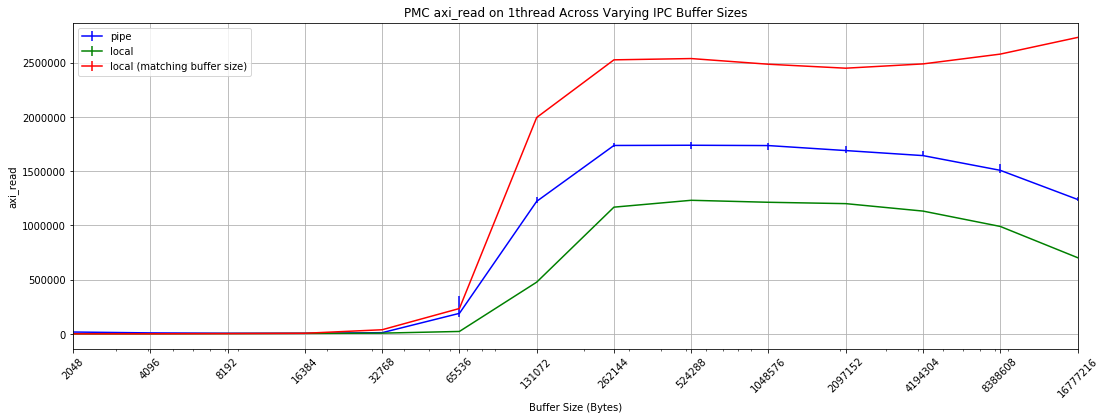

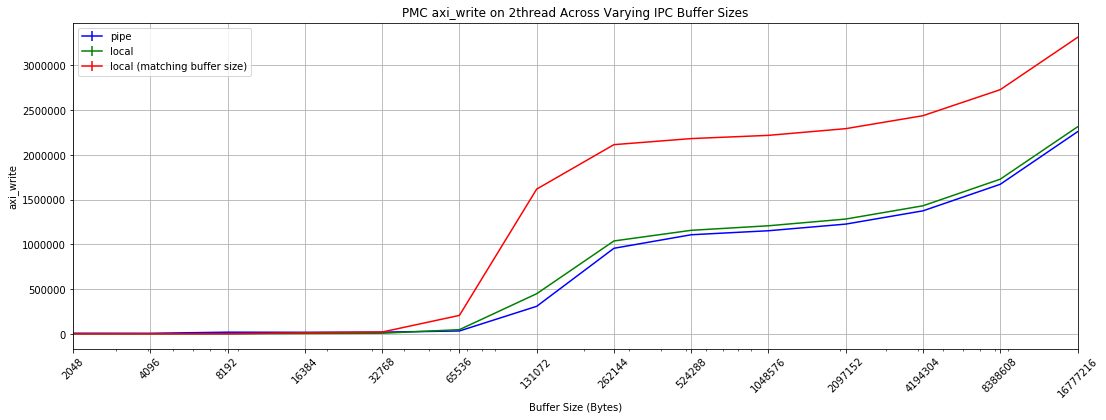

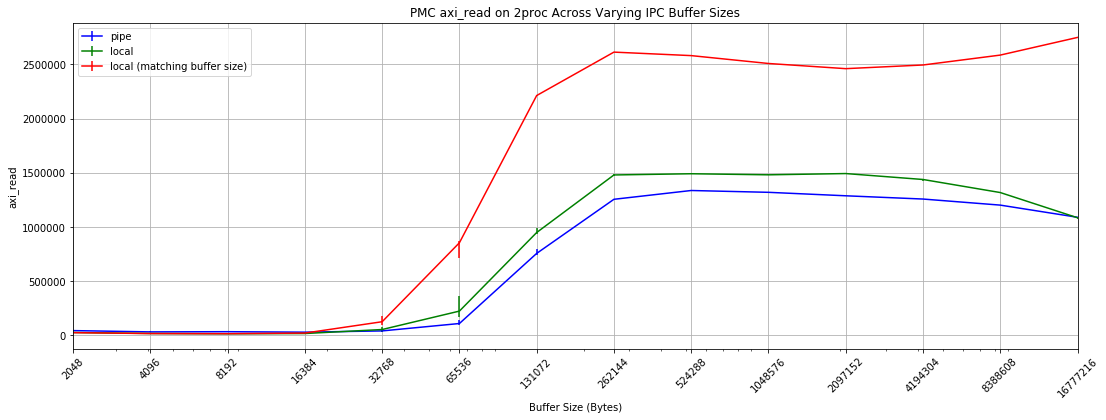

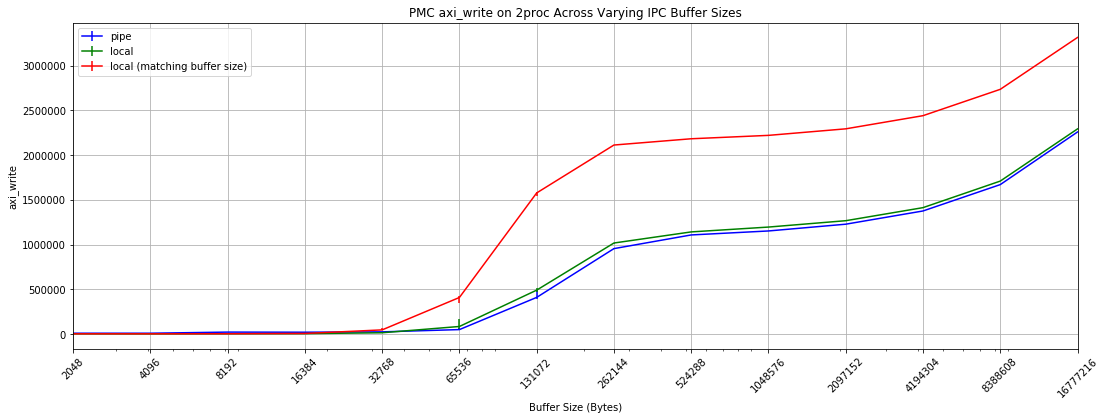

In [6]:
graph_pmc(["pipe", "local", "match"], "1thread", "axi", ["axi_read", "axi_write"])
graph_pmc(["pipe", "local", "match"], "2thread", "axi", ["axi_read", "axi_write"])
graph_pmc(["pipe", "local", "match"], "2proc", "axi", ["axi_read", "axi_write"])

	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
			2048 bytes 16777216 bytes: 155717.89 KBytes/sec
			4096 bytes 16777216 bytes: 193877.82 KBytes/sec
			8192 bytes 16777216 bytes: 208555.22 KBytes/sec
			16384 bytes 16777216 bytes: 227755.39 KBytes/sec
			32768 bytes 16777216 bytes: 218641.36 KBytes/sec
			65536 bytes 16777216 bytes: 200057.88 KBytes/sec
			131072 bytes 16777216 bytes: 127522.79 KBytes/sec
			262144 bytes 16777216 bytes: 103985.66 KBytes/sec
			524288 bytes 16777216 bytes: 99713.42 KBytes/sec
			1048576 bytes 16777216 bytes: 98577.91 KBytes/sec
			2097152 bytes 16777216 bytes: 96461.38 KBytes/sec
			4194304 bytes 16777216 bytes: 92011.69 KBytes/sec
			8388608 bytes 16777216 bytes: 85228.11 KBytes/sec
			16777216 bytes 16777216 bytes: 73229.20 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 130714.19 KBytes/sec
			4096 bytes 16777216 bytes: 171961.04 KBytes/sec
			8192 bytes 16777216 bytes: 192512.56 KBytes/sec
	

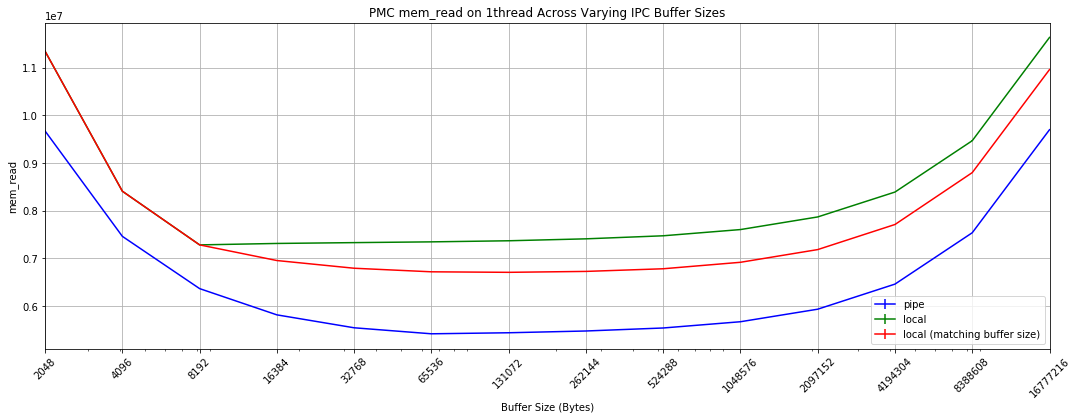

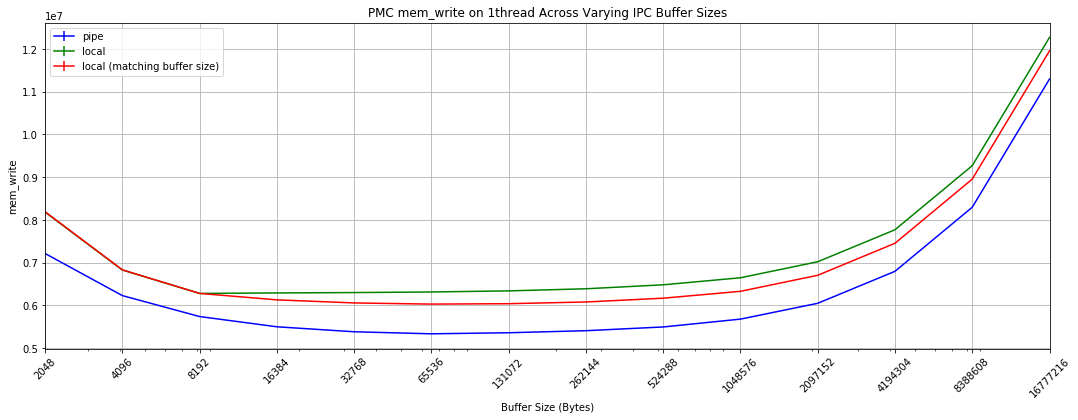

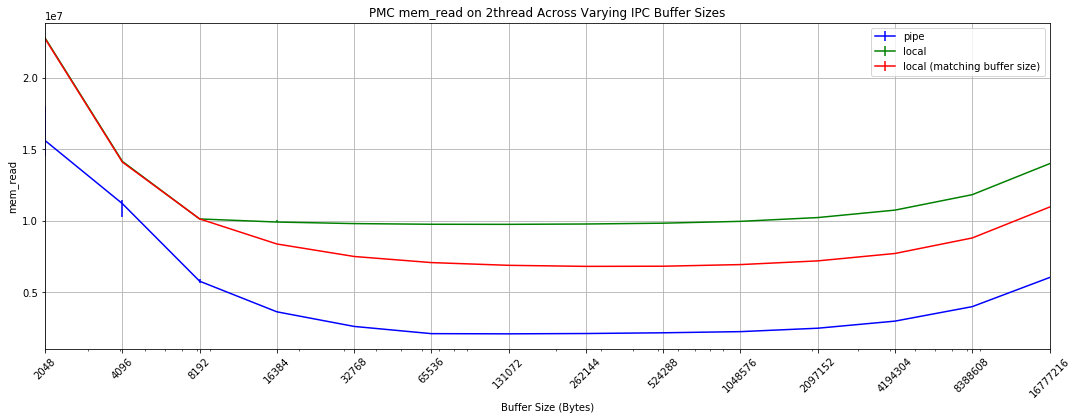

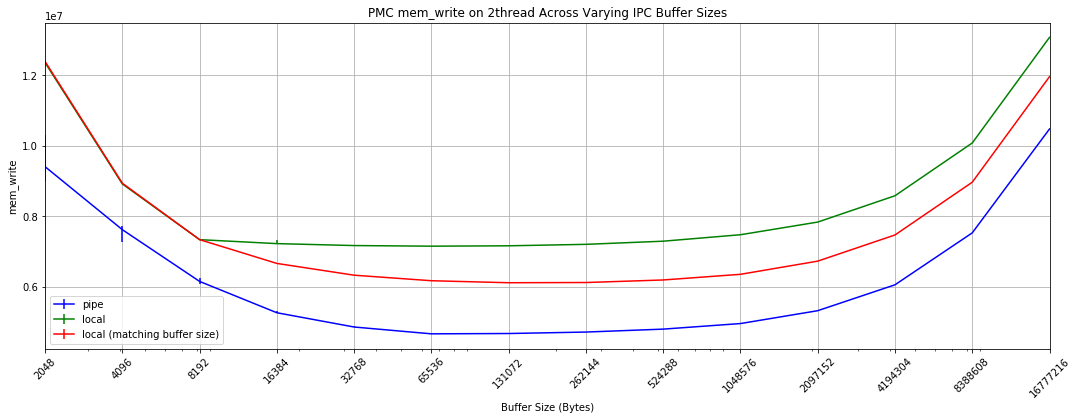

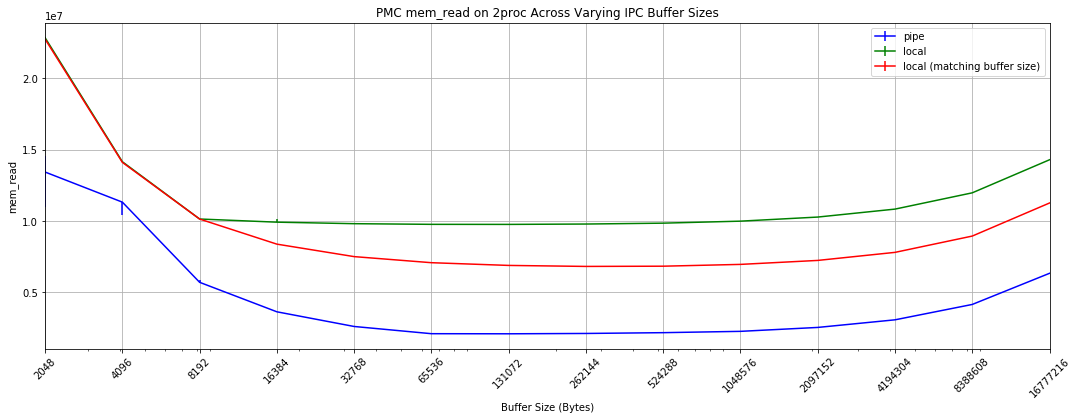

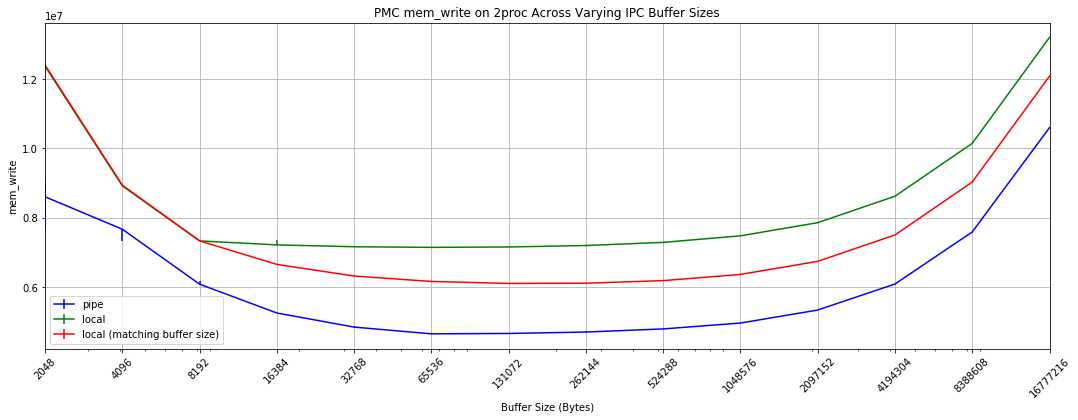

In [7]:
graph_pmc(["pipe", "local", "match"], "1thread", "mem", ["mem_read", "mem_write"])
graph_pmc(["pipe", "local", "match"], "2thread", "mem", ["mem_read", "mem_write"])
graph_pmc(["pipe", "local", "match"], "2proc", "mem", ["mem_read", "mem_write"])

In [ ]:
#TODO:
graph_pmc(["pipe", "local", "match"], "1thread", "l1d", ["l1d_refill", "l1d_hits"])
graph_pmc(["pipe", "local", "match"], "2thread", "l1d", ["l1d_refill", "l1d_hits"])
graph_pmc(["pipe", "local", "match"], "2proc", "l1d", ["l1d_refill", "l1d_hits"])

	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
			2048 bytes 16777216 bytes: 153869.50 KBytes/sec
			4096 bytes 16777216 bytes: 191144.94 KBytes/sec
			8192 bytes 16777216 bytes: 218411.32 KBytes/sec
			16384 bytes 16777216 bytes: 226831.06 KBytes/sec
			32768 bytes 16777216 bytes: 218513.60 KBytes/sec
			65536 bytes 16777216 bytes: 204763.70 KBytes/sec
			131072 bytes 16777216 bytes: 127608.51 KBytes/sec
			262144 bytes 16777216 bytes: 102999.43 KBytes/sec
			524288 bytes 16777216 bytes: 99994.99 KBytes/sec
			1048576 bytes 16777216 bytes: 98717.26 KBytes/sec
			2097152 bytes 16777216 bytes: 97701.93 KBytes/sec
			4194304 bytes 16777216 bytes: 92727.12 KBytes/sec
			8388608 bytes 16777216 bytes: 85047.03 KBytes/sec
			16777216 bytes 16777216 bytes: 74047.14 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 130458.76 KBytes/sec
			4096 bytes 16777216 bytes: 169558.75 KBytes/sec
			8192 bytes 16777216 bytes: 194650.12 KBytes/sec
	

	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
			2048 bytes 16777216 bytes: 159589.09 KBytes/sec
			4096 bytes 16777216 bytes: 213351.33 KBytes/sec
			8192 bytes 16777216 bytes: 254813.51 KBytes/sec
			16384 bytes 16777216 bytes: 264479.41 KBytes/sec
			32768 bytes 16777216 bytes: 252429.32 KBytes/sec
			65536 bytes 16777216 bytes: 216484.35 KBytes/sec
			131072 bytes 16777216 bytes: 135184.92 KBytes/sec
			262144 bytes 16777216 bytes: 111134.93 KBytes/sec
			524288 bytes 16777216 bytes: 106801.21 KBytes/sec
			1048576 bytes 16777216 bytes: 103615.29 KBytes/sec
			2097152 bytes 16777216 bytes: 102268.91 KBytes/sec
			4194304 bytes 16777216 bytes: 97159.99 KBytes/sec
			8388608 bytes 16777216 bytes: 89402.12 KBytes/sec
			16777216 bytes 16777216 bytes: 77182.92 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 142481.51 KBytes/sec
			4096 bytes 16777216 bytes: 191955.51 KBytes/sec
			8192 bytes 16777216 bytes: 218021.84 KBytes/se

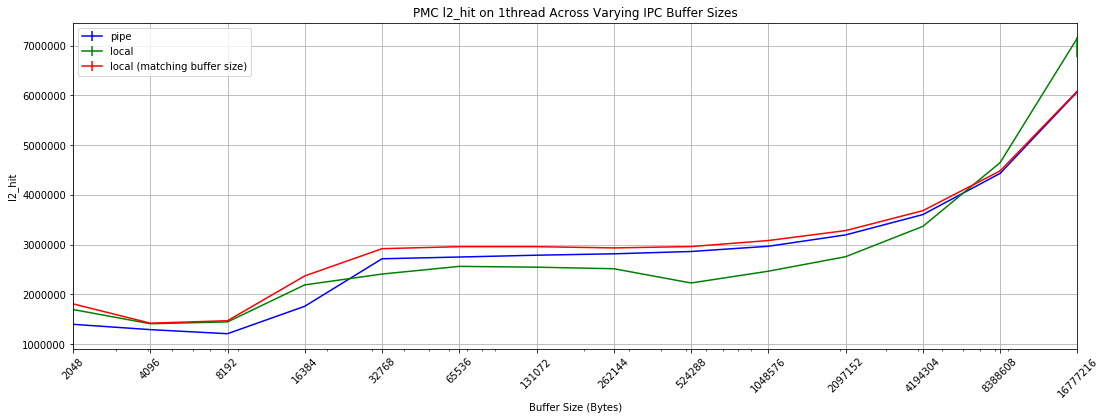

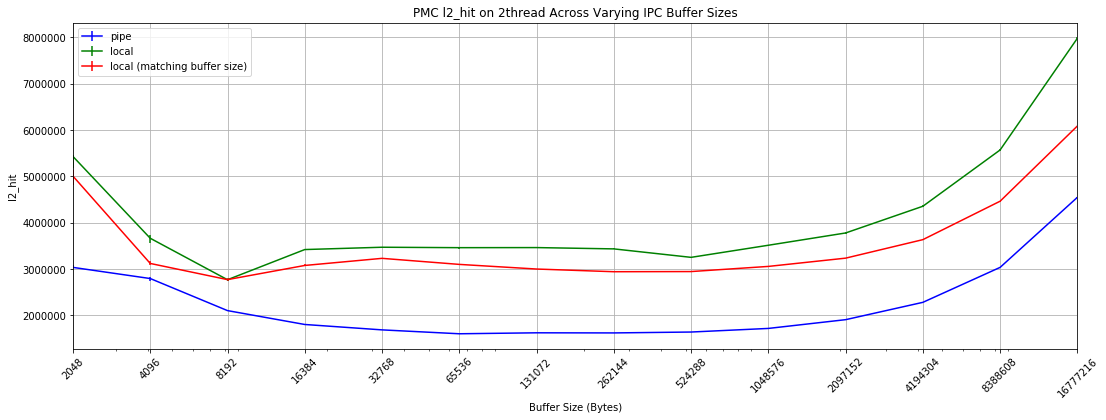

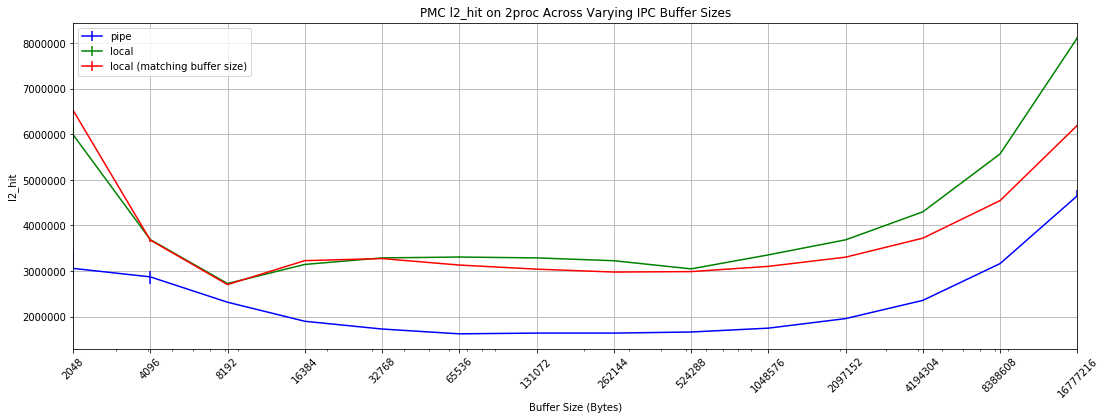

In [9]:
graph_pmc(["pipe", "local", "match"], "1thread", "l2", ["l2_hit"])
graph_pmc(["pipe", "local", "match"], "2thread", "l2", ["l2_hit"])
graph_pmc(["pipe", "local", "match"], "2proc", "l2", ["l2_hit"])

	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
			2048 bytes 16777216 bytes: 147932.82 KBytes/sec
			4096 bytes 16777216 bytes: 194509.62 KBytes/sec
			8192 bytes 16777216 bytes: 220641.49 KBytes/sec
			16384 bytes 16777216 bytes: 227802.20 KBytes/sec
			32768 bytes 16777216 bytes: 218815.96 KBytes/sec
			65536 bytes 16777216 bytes: 189710.59 KBytes/sec
			131072 bytes 16777216 bytes: 126046.24 KBytes/sec
			262144 bytes 16777216 bytes: 103399.28 KBytes/sec
			524288 bytes 16777216 bytes: 99750.06 KBytes/sec
			1048576 bytes 16777216 bytes: 98201.01 KBytes/sec
			2097152 bytes 16777216 bytes: 96672.47 KBytes/sec
			4194304 bytes 16777216 bytes: 92214.23 KBytes/sec
			8388608 bytes 16777216 bytes: 85460.15 KBytes/sec
			16777216 bytes 16777216 bytes: 73477.13 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 1thread
			2048 bytes 16777216 bytes: 130164.17 KBytes/sec
			4096 bytes 16777216 bytes: 171273.83 KBytes/sec
			8192 bytes 16777216 bytes: 192622.17 KBytes/sec
	

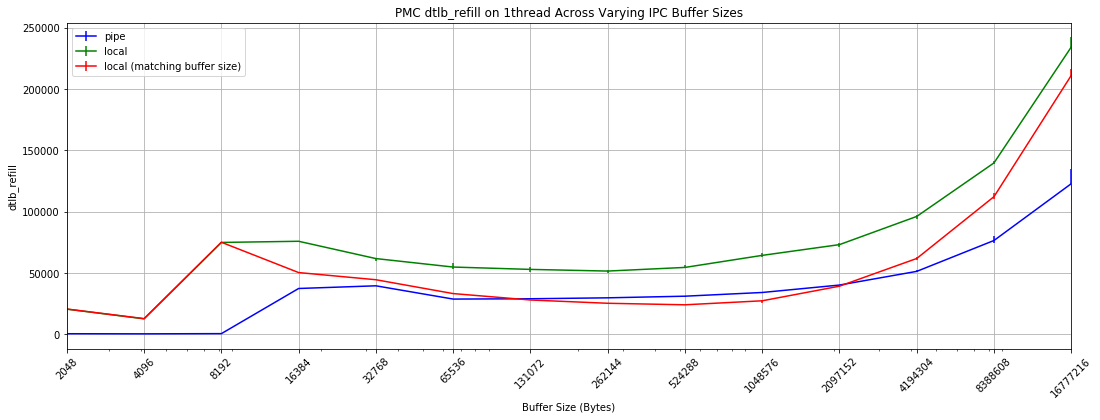

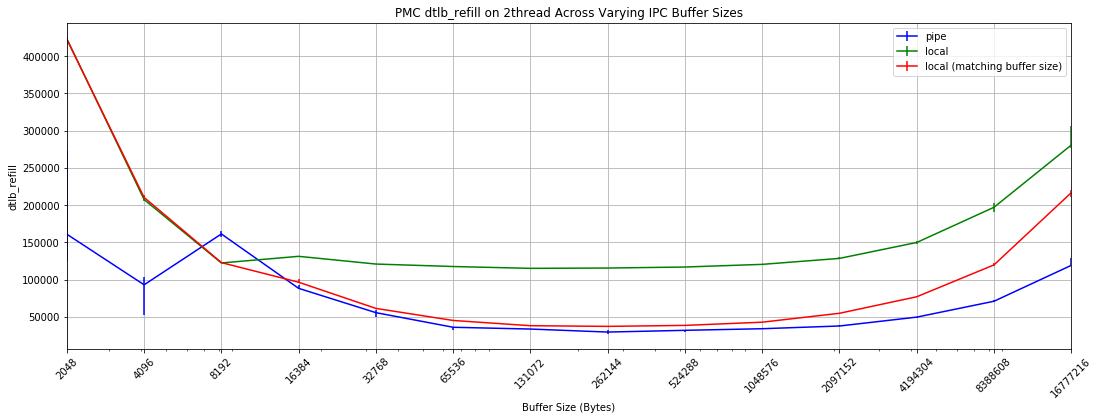

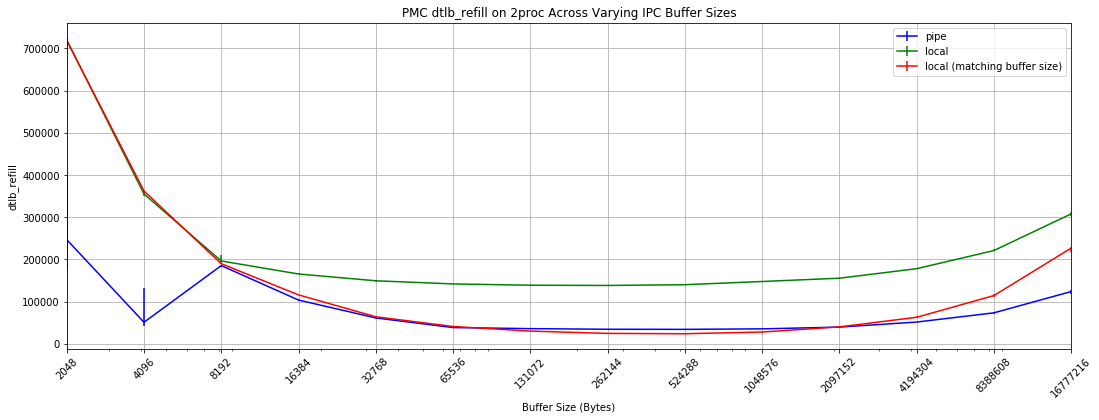

In [ ]:
graph_pmc(["pipe", "local", "match"], "1thread", "tlb", ["dtlb_refill"])
graph_pmc(["pipe", "local", "match"], "2thread", "tlb", ["dtlb_refill"])
graph_pmc(["pipe", "local", "match"], "2proc", "tlb", ["dtlb_refill"])

	 ==> Running ipc/ipc-static
		 ==> local across 2thread
			2048 bytes 16777216 bytes: 54398.15 KBytes/sec
			4096 bytes 16777216 bytes: 90369.94 KBytes/sec
			8192 bytes 16777216 bytes: 133907.36 KBytes/sec
			16384 bytes 16777216 bytes: 135777.52 KBytes/sec
			32768 bytes 16777216 bytes: 135874.98 KBytes/sec
			65536 bytes 16777216 bytes: 124604.95 KBytes/sec
			131072 bytes 16777216 bytes: 99382.65 KBytes/sec
			262144 bytes 16777216 bytes: 83699.12 KBytes/sec
			524288 bytes 16777216 bytes: 81594.41 KBytes/sec
			1048576 bytes 16777216 bytes: 80144.57 KBytes/sec
			2097152 bytes 16777216 bytes: 77861.47 KBytes/sec
			4194304 bytes 16777216 bytes: 74896.52 KBytes/sec
			8388608 bytes 16777216 bytes: 68470.70 KBytes/sec
			16777216 bytes 16777216 bytes: 58117.26 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 2proc
			2048 bytes 16777216 bytes: 44524.81 KBytes/sec
			4096 bytes 16777216 bytes: 76735.38 KBytes/sec
			8192 bytes 16777216 bytes: 118114.32 KBytes/sec
			16384

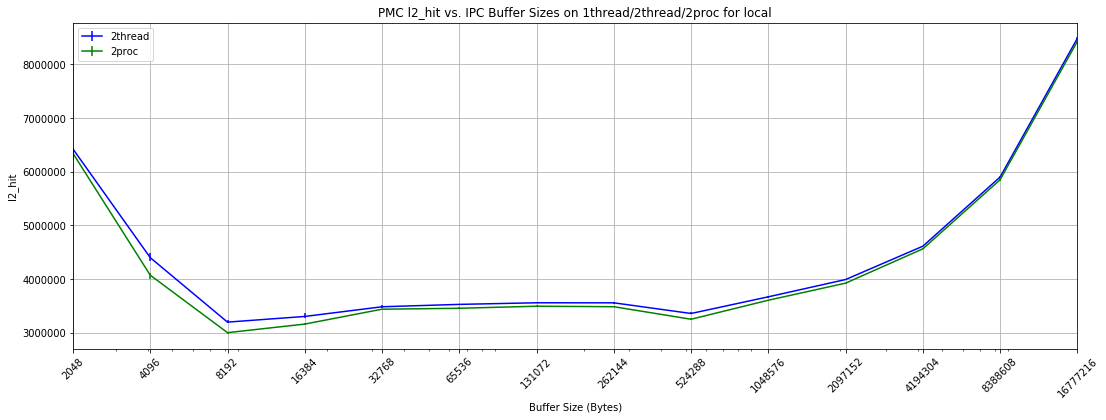

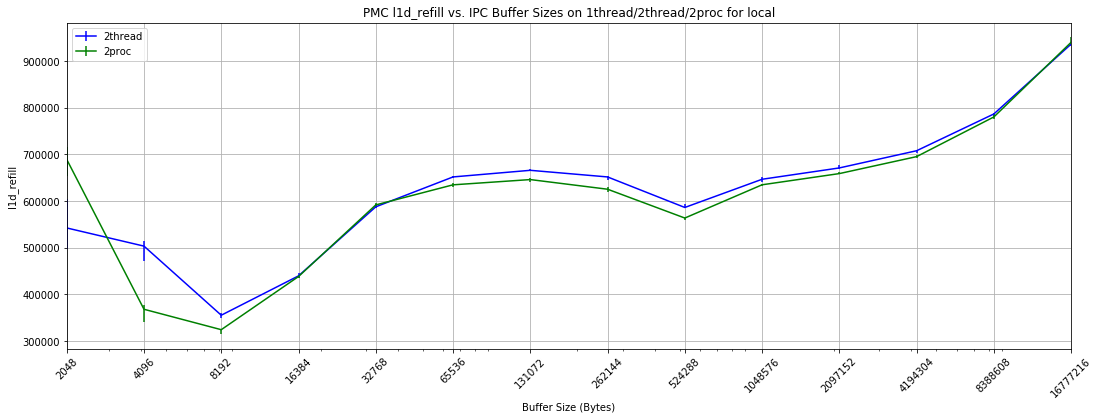

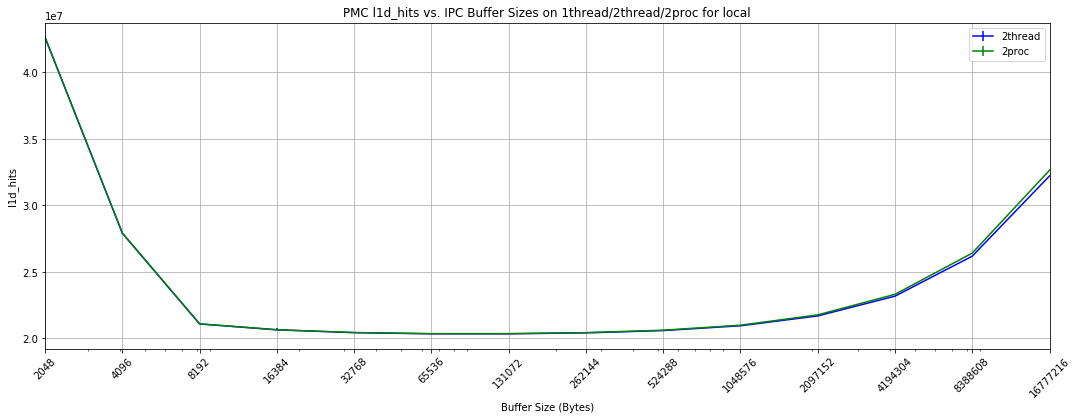

In [31]:
graph_mc_pmc("local", ["2thread", "2proc"], "l2", ["l2_hit"])
graph_mc_pmc("local", ["2thread", "2proc"], "l1d", ["l1d_refill", "l1d_hits"])

	 ==> Running ipc/ipc-static
		 ==> pipe across 2thread
			2048 bytes 16777216 bytes: 100137.28 KBytes/sec
			4096 bytes 16777216 bytes: 134577.38 KBytes/sec
			8192 bytes 16777216 bytes: 146568.30 KBytes/sec
			16384 bytes 16777216 bytes: 195076.74 KBytes/sec
			32768 bytes 16777216 bytes: 234236.23 KBytes/sec
			65536 bytes 16777216 bytes: 238055.14 KBytes/sec
			131072 bytes 16777216 bytes: 166843.95 KBytes/sec
			262144 bytes 16777216 bytes: 124456.80 KBytes/sec
			524288 bytes 16777216 bytes: 115857.05 KBytes/sec
			1048576 bytes 16777216 bytes: 114899.76 KBytes/sec
			2097152 bytes 16777216 bytes: 111776.11 KBytes/sec
			4194304 bytes 16777216 bytes: 106721.99 KBytes/sec
			8388608 bytes 16777216 bytes: 97981.81 KBytes/sec
			16777216 bytes 16777216 bytes: 84050.04 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 2proc
			2048 bytes 16777216 bytes: 86511.72 KBytes/sec
			4096 bytes 16777216 bytes: 117925.72 KBytes/sec
			8192 bytes 16777216 bytes: 126122.28 KBytes/sec
	

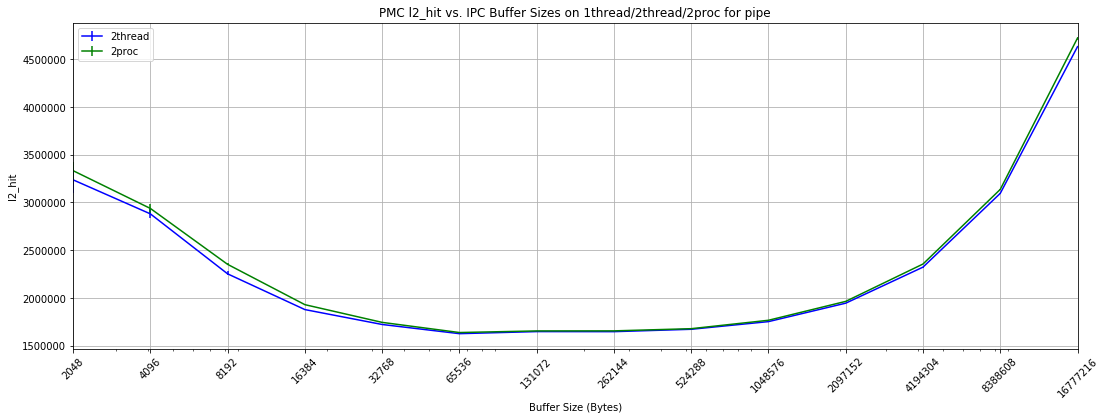

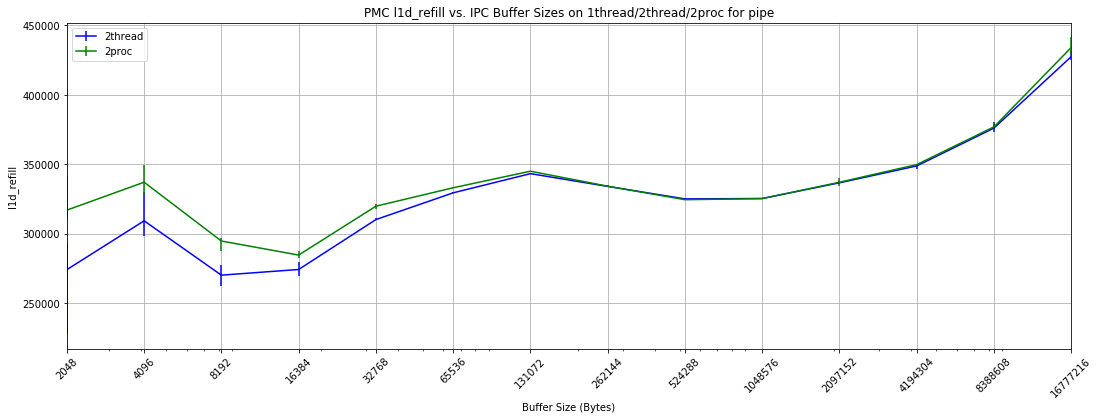

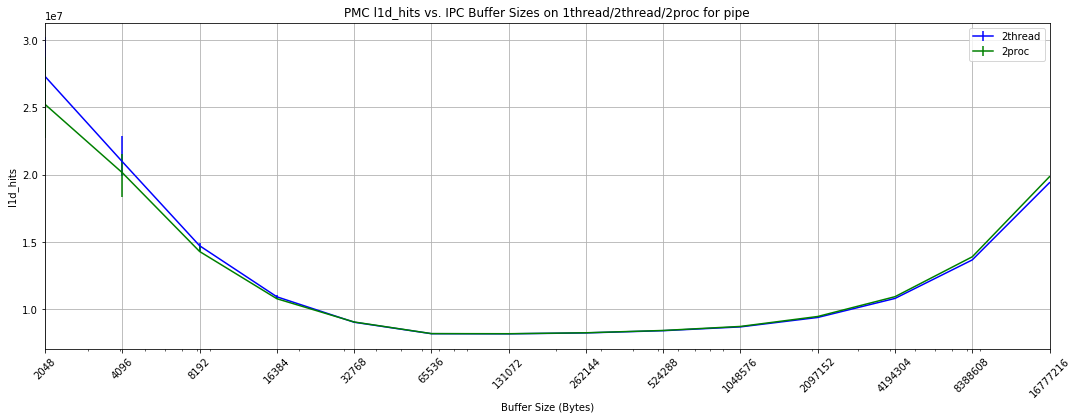

In [27]:
graph_mc_pmc("pipe", ["2thread", "2proc"], "l2", ["l2_hit"])
graph_mc_pmc("pipe", ["2thread", "2proc"], "l1d", ["l1d_refill", "l1d_hits"])

	 ==> Running ipc/ipc-static
		 ==> local across 2thread
			2048 bytes 16777216 bytes: 50718.17 KBytes/sec
			4096 bytes 16777216 bytes: 83202.04 KBytes/sec
			8192 bytes 16777216 bytes: 117256.09 KBytes/sec
			16384 bytes 16777216 bytes: 122318.46 KBytes/sec
			32768 bytes 16777216 bytes: 121912.59 KBytes/sec
			65536 bytes 16777216 bytes: 111553.60 KBytes/sec
			131072 bytes 16777216 bytes: 91724.35 KBytes/sec
			262144 bytes 16777216 bytes: 78326.48 KBytes/sec
			524288 bytes 16777216 bytes: 76273.11 KBytes/sec
			1048576 bytes 16777216 bytes: 75358.97 KBytes/sec
			2097152 bytes 16777216 bytes: 73178.16 KBytes/sec
			4194304 bytes 16777216 bytes: 68536.20 KBytes/sec
			8388608 bytes 16777216 bytes: 64910.03 KBytes/sec
			16777216 bytes 16777216 bytes: 55692.31 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> local across 2proc
			2048 bytes 16777216 bytes: 41781.03 KBytes/sec
			4096 bytes 16777216 bytes: 71317.19 KBytes/sec
			8192 bytes 16777216 bytes: 107188.36 KBytes/sec
			16384

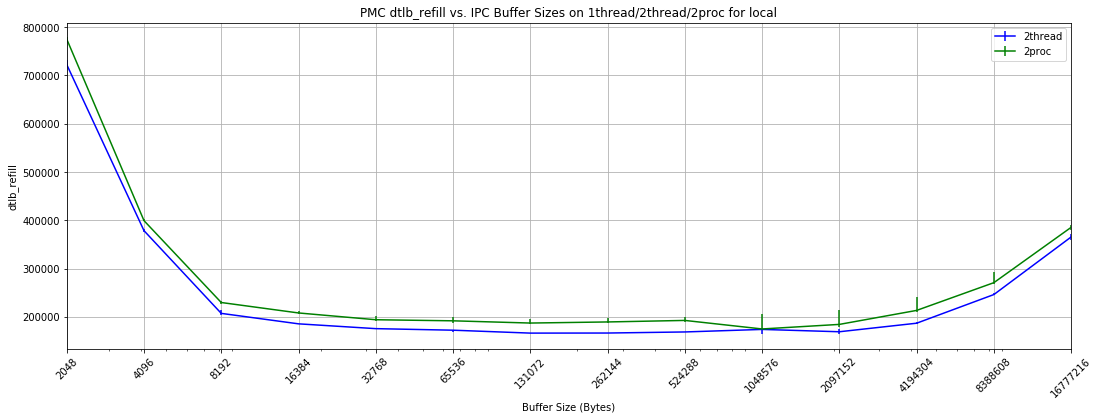

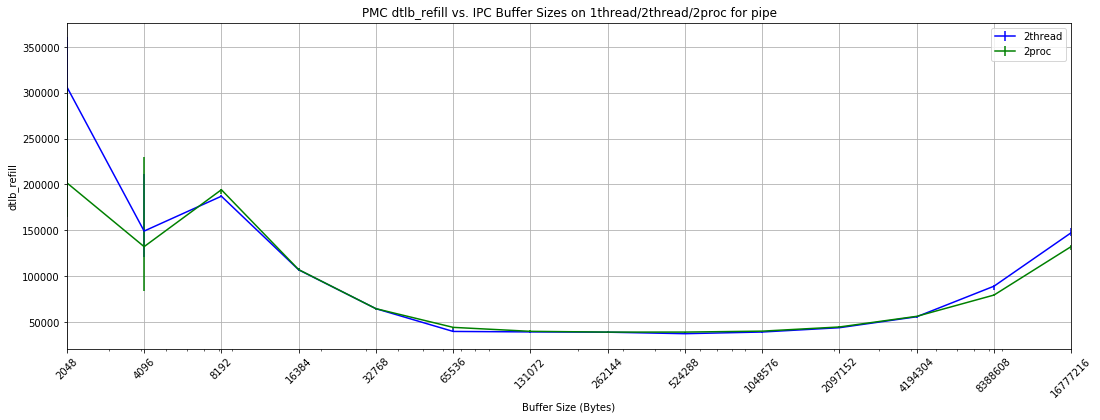

In [30]:
graph_mc_pmc("local", ["2thread", "2proc"], "tlb", ["dtlb_refill"])
graph_mc_pmc("pipe", ["2thread", "2proc"], "tlb", ["dtlb_refill"])

In [ ]:
#TODO
graph_mc_pmc("pipe", ["2thread", "2proc"], "mem", ["cycles_per_instr"])
graph_mc_pmc("local", ["2thread", "2proc"], "mem", ["cycles_per_instr"])

	 ==> Running ipc/ipc-static
		 ==> pipe across 2thread
			2048 bytes 16777216 bytes: 94058.26 KBytes/sec
			4096 bytes 16777216 bytes: 123086.97 KBytes/sec
			8192 bytes 16777216 bytes: 129184.94 KBytes/sec
			16384 bytes 16777216 bytes: 171434.27 KBytes/sec
			32768 bytes 16777216 bytes: 202703.98 KBytes/sec
			65536 bytes 16777216 bytes: 208170.36 KBytes/sec
			131072 bytes 16777216 bytes: 154160.73 KBytes/sec
			262144 bytes 16777216 bytes: 114485.13 KBytes/sec
			524288 bytes 16777216 bytes: 107862.82 KBytes/sec
			1048576 bytes 16777216 bytes: 107189.26 KBytes/sec
			2097152 bytes 16777216 bytes: 104001.53 KBytes/sec
			4194304 bytes 16777216 bytes: 99770.65 KBytes/sec
			8388608 bytes 16777216 bytes: 92278.32 KBytes/sec
			16777216 bytes 16777216 bytes: 80217.88 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 2proc
			2048 bytes 16777216 bytes: 106668.92 KBytes/sec
			4096 bytes 16777216 bytes: 124681.02 KBytes/sec
			8192 bytes 16777216 bytes: 112950.51 KBytes/sec
		

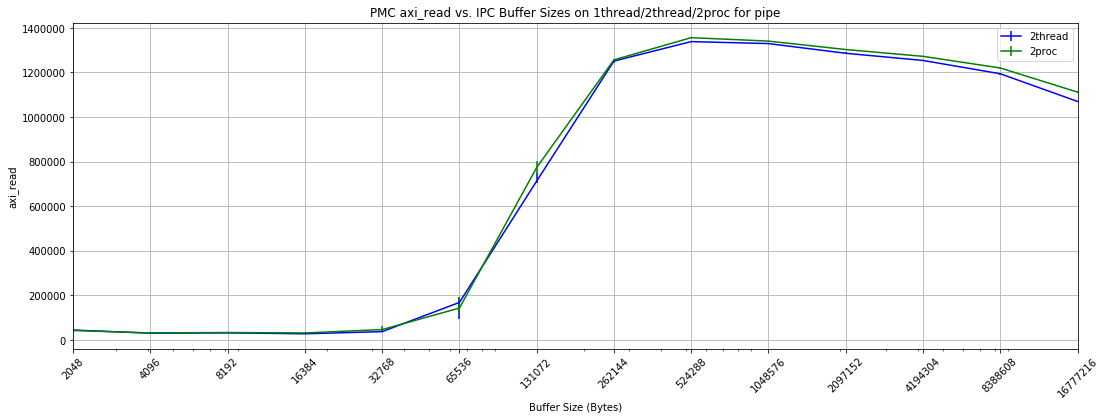

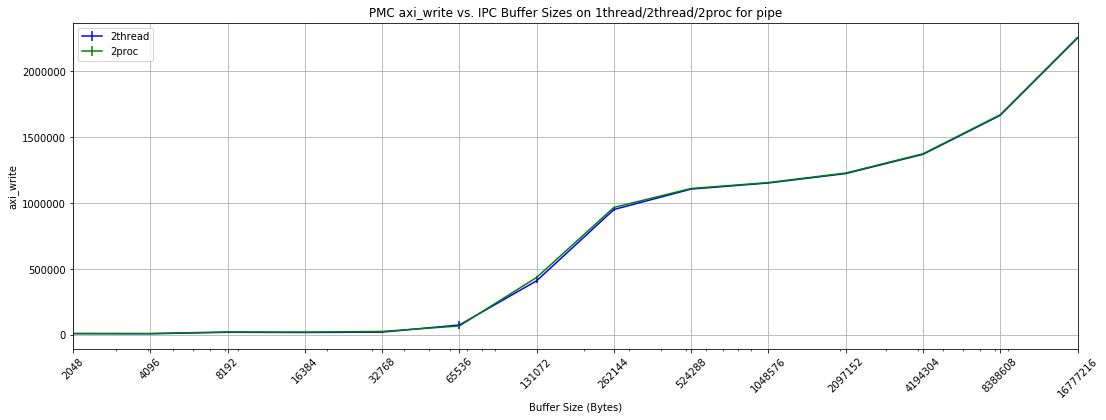

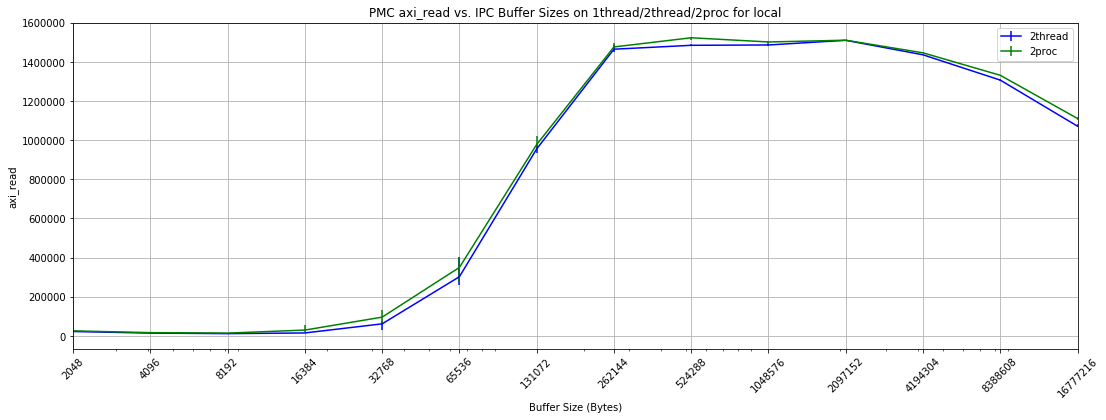

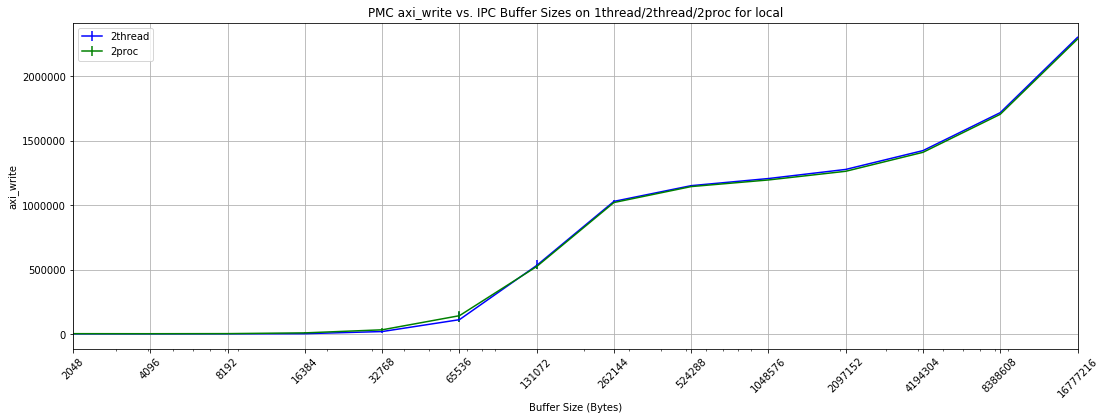

In [32]:
graph_mc_pmc("pipe", ["2thread", "2proc"], "axi", ["axi_read", "axi_write"])
graph_mc_pmc("local", ["2thread", "2proc"], "axi", ["axi_read", "axi_write"])

In [ ]:
# TODO
graph_mc_pmc("local", ["2thread", "2proc"], "mem", ["mem_write_per_cycle"])
graph_mc_pmc("local", ["2thread", "2proc"], "mem", ["mem_read_per_cycle"])
graph_mc_pmc("pipe", ["2thread", "2proc"], "mem", ["mem_write_per_cycle"])
graph_mc_pmc("pipe", ["2thread", "2proc"], "mem", ["mem_read_per_cycle"])

In [ ]:
# TODO
graph_mc_pmc("local", ["2thread", "2proc"], "tlb", ["itlb_refill"])
graph_mc_pmc("local", ["2thread", "2proc"], "l2", ["l2_hit_per_cycle"])
graph_mc_pmc("local", ["2thread", "2proc"], "l1d", ["l1d_refill_per_cycle"])
graph_mc_pmc("local", ["2thread", "2proc"], "l1i", ["l1i_refill_per_cycle"])

graph_mc_pmc("pipe", ["2thread", "2proc"], "tlb", ["itlb_refill"])
graph_mc_pmc("pipe", ["2thread", "2proc"], "l2", ["l2_hit_per_cycle"])
graph_mc_pmc("pipe", ["2thread", "2proc"], "l1d", ["l1d_refill_per_cycle"])
graph_mc_pmc("pipe", ["2thread", "2proc"], "l1i", ["l1i_refill_per_cycle"])

# Esoteric
* TODO: measure nosleep

In [ ]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]]
RUNS = 20
EXE="ipc/ipc-static-nonblock"
FLAGS=""
IPC= "pipe"

MODE = "1thread"
#thread1 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(thread1, "./mc_nonblock_pipe_1thread.pkl")
thread1 = pd.read_pickle("pkls/mc_nonblock_pipe_1thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread1]), RUNS,
          xlabel='IPC Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)',
          label=MODE, title = "Throughput vs. IPC Buffer Size For Three Thread Models (pipe, no non-blocking I/O)")

MODE = "2thread"
#thread2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(thread2, "./mc_nonblock_pipe_2thread.pkl")
thread2 = pd.read_pickle("pkls/mc_nonblock_pipe_2thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread2]), RUNS,
          label=MODE, axis = p)

MODE = "2proc"
#proc2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(proc2, "./mc_nonblock_pipe_2proc.pkl")
proc2 = pd.read_pickle("pkls/mc_nonblock_pipe_2proc.pkl")
highlight(p, texty = 75000)
saveas = genfilename(EXE, MODE, "pipe", RUNS, FLAGS, suffix = "vary_thread_model_nonblock")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in proc2]), RUNS, axis = p,
          label=MODE, save = True, save_name = saveas)

In [ ]:
!sysctl kern.ipc.piperesizeallowed=0
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]]
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""
IPC= "pipe"

MODE = "1thread"
#thread1 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(thread1, "./mc_pipe_1thread_noresize.pkl")
thread1 = pd.read_pickle("pkls/mc_pipe_1thread_noresize.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread1]), RUNS,
          xlabel='IPC Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)',
          label=MODE, title = "Throughput vs. IPC Buffer Size For Three Thread Models (pipe, pipe resize disabled)")

MODE = "2thread"
#thread2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(thread2, "./mc_pipe_2thread_noresize.pkl")
thread2 = pd.read_pickle("pkls/mc_pipe_2thread_noresize.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread2]), RUNS,
          label=MODE, axis = p)

MODE = "2proc"
#proc2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(proc2, "./mc_pipe_2proc_noresize.pkl")
proc2 = pd.read_pickle("pkls/mc_pipe_2proc_noresize.pkl")
highlight(p, texty = 75000)
saveas = genfilename(EXE, MODE, "pipe", RUNS, FLAGS, suffix = "vary_thread_model_noresize")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in proc2]), RUNS, axis = p,
          label=MODE, save = True, save_name = saveas)

!sysctl kern.ipc.piperesizeallowed=1

## uio/tcp/ip/uipc/mbuf/vm_fault counts/mi_switch/uiomove/uiomove_fromphys

In [ ]:
MODE = "2thread"
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]]
IPC= "pipe"
RUNS=1
results = {}
for tot_sz in TOT_SIZES:
    for buf_sz in BUFFER_SIZES:
        values = [] # Change depending on agg function. E.g. could be init'd to {}
        benchmark(FLAGS, RUNS, EXE, MODE, IPC, [buf_sz], [tot_sz], dtrace_info = {'agg_fn':test_agg, 'script':D_ctx_switch})
        #results[buf_sz] = values
        print(results)

## Initial PMC observations

* axi_reads increase at 32KB for **pipe 1thread** which coincides with the bandwidth inflection point

# Statistical Analysis

* do null hypothesis test on mean for thread models for pipe vs local; do null hypothesis test on local with and without matching buffers
* median test using scipy->run 10 and 20 runs of benchmark for hypothesis tests->plot p-value as buffer size increases
* test for statistical difference in matching vs. non-matching socketpairs
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html
* https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/meditest.htm
* https://en.wikipedia.org/wiki/Median_test
* https://www.cl.cam.ac.uk/teaching/1819/L41/notes/2018-2019-l41-lab-1-io-notes.pdf

# Notes

** TODO **
1. DTrace investigations
2. static/dynamic benchmarks (whole program analysis using time(1))
3. probe effect (run timing benchmark with dtrace and without)
4. performance counters

Investigation of IPC syscalls such as pipe(2) and socket(2). read(2) and write(2) can be performed on sockets and pipes and allow for partial reads and writes. This implies that it is possible for only a subset of a requested buffer size to be read or written. Possible causes are size limits of in-kernel IPC buffers or use of non-blocking I/O. Input and output bytes both need to be considered during benchmarking performance of IPC syscalls.

Links:
* https://www.freebsd.org/cgi/man.cgi?query=socket&sektion=2
* https://www.freebsd.org/cgi/man.cgi?pipe(2)
* https://wiki.freebsd.org/NetworkPerformanceTuning
* https://wiki.freebsd.org/BenchmarkAdvice
* Pipe sizes: https://github.com/openbsd/src/blob/master/sys/sys/pipe.h
* https://github.com/freebsd/freebsd/blob/6aeb44070cfcb3431ef7e206201f7272e6804067/sys/kern/sys_pipe.c#L1061
* https://www.freebsd.org/cgi/man.cgi?query=pipe&sektion=7&manpath=SuSE+Linux/i386+11.3
* http://www.leidinger.net/FreeBSD/dox/vm/html/d7/dbb/vm__phys_8h.html#ad7893b435b2c5b11556fa000656c1318: vm_phys_paddr_to_vm_page

Benchmark:
* Set up IPC endpoints (using pipe(2) or socket(2))
* Transfer bytes from a user-space buffer using read(2)/write(2)
  * ! there is no guarantee for all bytes to be transferred however
* Modes of rx/tx operations are:
  * within single thread
  * between pair of threads in same process
  * between threads in two different processes
* Time is measured via clock_gettime(2)
* Both statically and dynamically linked version available

* -i: IPC object type (pipe, local i.e. socketpair(2), tcp i.e. socket(2))
* -t: total size of I/O file | default: 16777216
* -b: user-space IPC buffer size (bytes) | default: 131072
* 1thread, 2thread, 2proc

Testsuite:
* 1st thread/proc is receiver
* 2nd thread/proc is sender
* Sender writes timestamp to shared memory before sending bytes
  * sender_argument.sa_starttime
* Sender:
  * call write(2) with buffersize or remaining bytes to write (whichever is lower)
  * repeat writes until total I/O size is reached
* Receiver:
  * call read(2) until total I/O size has been reached
* Multiple Processes/Threads:
  * Create page (mmap(2)) for sender_argument struct
  * Set inheritance property (minherit(2)) such that the address space of the page can be shared between parent and child
  * Receive or send depending on pid
  * Return time difference
* Single thread:
  * Set non-blocking I/O flags on input file descriptors (O_NONBLOCKING from pipe(2))
  * Perform read and write in same iteration until total I/O size is reached
    * In the first iteration of the benchmark only a read can be performed unless we block because the first read failed
  * One of read or write is definitely performed at each iteration (block until rx or tx is ready if necessary (using select(2))
  * Return time of I/O loop
* Main:
  * Allocate IPC object: tcp socket, pipe, local socket
  * Prepare IPC buffer sizes if necessary
  * fsync(2) and sleep if necessary
  * Start benchmark modes
  * Print output if necessary

Source References:
* High performance pipe implementation: sys/kern/sys_pipe.c

Call chains:
* for (1thread) tcp/socketpair: soowrite -> sosend -> uiomove_faultflag
* for (1thread) tcp/socketpair: sys_read -> kern_readv -> dofileread -> uiomove_faultflag
* uiomove_faultflag is the only uiomove routine called
* Call stack for vm_fault (1thread tpc):
             `kernel `vm_fault
              kernel`exception_exit
              kernel`copyin+0x188
              kernel`uiomove_faultflag+0x10c
              kernel`m_uiotombuf+0x118
              kernel`sosend_generic+0x568
              kernel`soo_write+0x3c
              kernel`dofilewrite+0xa8
              kernel`kern_writev+0x78
              kernel`sys_write+0x4c
              kernel`swi_handler+0x6d8
              kernel`swi_exit
              kernel`swi_exit

* Socket read is in blocking mode
* Socket write and pipe read/write are in non-blocking mode
* socketpair has highest number off-cpu switches
* sysctl net | grep 8192